In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tsgm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
#Set Global Random Seed
global_seed = 8
tf.random.set_seed(global_seed)
np.random.seed(global_seed)

In [3]:
#Save Kyoto_Gases data (2020-2100), consider the case of C1-C8 for simplicity.
Kyoto_Gases = pd.read_csv('Kyoto Gases.csv')
Kyoto_Gases = Kyoto_Gases[Kyoto_Gases['Category'].isin(['C1','C2','C3','C4','C5','C6','C7','C8'])]
mapping = {'C1':0,'C2':0,'C3':0,'C4':1,'C5':1,'C6':1,'C7':2,'C8':2}
Kyoto_Gases['Category'].replace(mapping,inplace=True)
Kyoto_Gases.reset_index(drop=True,inplace=True)

In [4]:
Kyoto_Gases.drop(columns=['Category_name'],inplace = True)

In [5]:
#Load a dataset of individual variables
CarbonSequestration = pd.read_csv('Carbon_Sequestration_CCS_imputed.csv')
FinalEnergy_Liquid = pd.read_csv('Final Energy_Liquids.csv')
PrimaryEnergy_Gas = pd.read_csv('Primary Energy_Gas.csv')
PrimaryEnergy_Oil = pd.read_csv('Primary Energy_Oil.csv')
PrimaryEnergy_Coal = pd.read_csv('PrimaryEnergy_Coal.csv')

In [6]:
#Get the intersection of the models and scenarios contained in each variable
Model_Scenario = Kyoto_Gases[['Model','Scenario']]
Variables = [CarbonSequestration,FinalEnergy_Liquid,PrimaryEnergy_Coal,PrimaryEnergy_Gas,PrimaryEnergy_Oil]
for variable in Variables:
    Model_Scenario = pd.merge(Model_Scenario,variable[['Model','Scenario']],on=['Model','Scenario'],how='inner')

In [7]:
for i in range(len(Variables)):
    Variables[i] = pd.merge(Model_Scenario,Variables[i],on=['Model','Scenario'],how='inner')
for i in range(len(Variables)):
    Variables[i].drop(columns=['Category_name'],inplace = True)
    

In [8]:
Kyoto_Gases = pd.merge(Kyoto_Gases,Model_Scenario,on = ['Model','Scenario'],how = 'inner')

In [9]:
Variables.append(Kyoto_Gases)
#Variables [CarbonSequestration,FinalEnergy_Liquid,PrimaryEnergy_Coal,PrimaryEnergy_Gas,PrimaryEnergy_Oil,Kyoto_Gases]

In [10]:
#Generate feature matrices, the values of each variable during 2020-2100. 9 time steps, 6 features
#1160 is the amount of data
X = np.zeros((1160,9,6))
for i in range(len(Variables)):
    Variables[i] = Variables[i].iloc[:,3:-1].values
for i in range(1160):
    for j in range(9):
        for k in range(6):
            X[i][j][k] = (Variables[k])[i,j]

In [11]:
Y = Kyoto_Gases['Category'].values

In [12]:
#Separate datasets by category. 
C123_DataSet = X[Y == 0]
C456_DataSet = X[Y == 1]
C78_DataSet = X[Y == 2]

In [13]:
architecture1 = tsgm.models.zoo["vae_conv5"](9, 6, 8)#Latent Dim = 8
encoder1, decoder1 = architecture1.encoder, architecture1.decoder

In [14]:
scaler_C123 = tsgm.utils.TSFeatureWiseScaler((0,1))        
scaled_C123_data = scaler_C123.fit_transform(C123_DataSet)

In [15]:
architecture2 = tsgm.models.zoo["vae_conv5"](9, 6, 8)
encoder2, decoder2 = architecture2.encoder, architecture2.decoder
scaler_C456 = tsgm.utils.TSFeatureWiseScaler((0,1))    
scaled_C456_data = scaler_C456.fit_transform(C456_DataSet)

In [16]:
architecture3 = tsgm.models.zoo["vae_conv5"](9, 6, 8)
encoder3, decoder3 = architecture3.encoder, architecture3.decoder
scaler_C78 = tsgm.utils.TSFeatureWiseScaler((0,1))    
scaled_C78_data = scaler_C78.fit_transform(C78_DataSet)

In [17]:
#Load model parameters
encoder1.load_weights('encoder1_weights.h5')
encoder2.load_weights('encoder2_weights.h5')
encoder3.load_weights('encoder3_weights.h5')
decoder1.load_weights('decoder1_weights.h5')
decoder2.load_weights('decoder2_weights.h5')
decoder3.load_weights('decoder3_weights.h5')

In [18]:
#Generate data using generative models (500 for each class)
z1 = tf.random.normal((500, 8))
z2 = tf.random.normal((500, 8))
z3 = tf.random.normal((500, 8))
Gen_C123 = decoder1(z1)
Gen_C456 = decoder2(z2)
Gen_C78 = decoder3(z3)
Gen_C123 = scaler_C123.inverse_transform(Gen_C123)
Gen_C456 = scaler_C456.inverse_transform(Gen_C456)
Gen_C78 = scaler_C78.inverse_transform(Gen_C78)

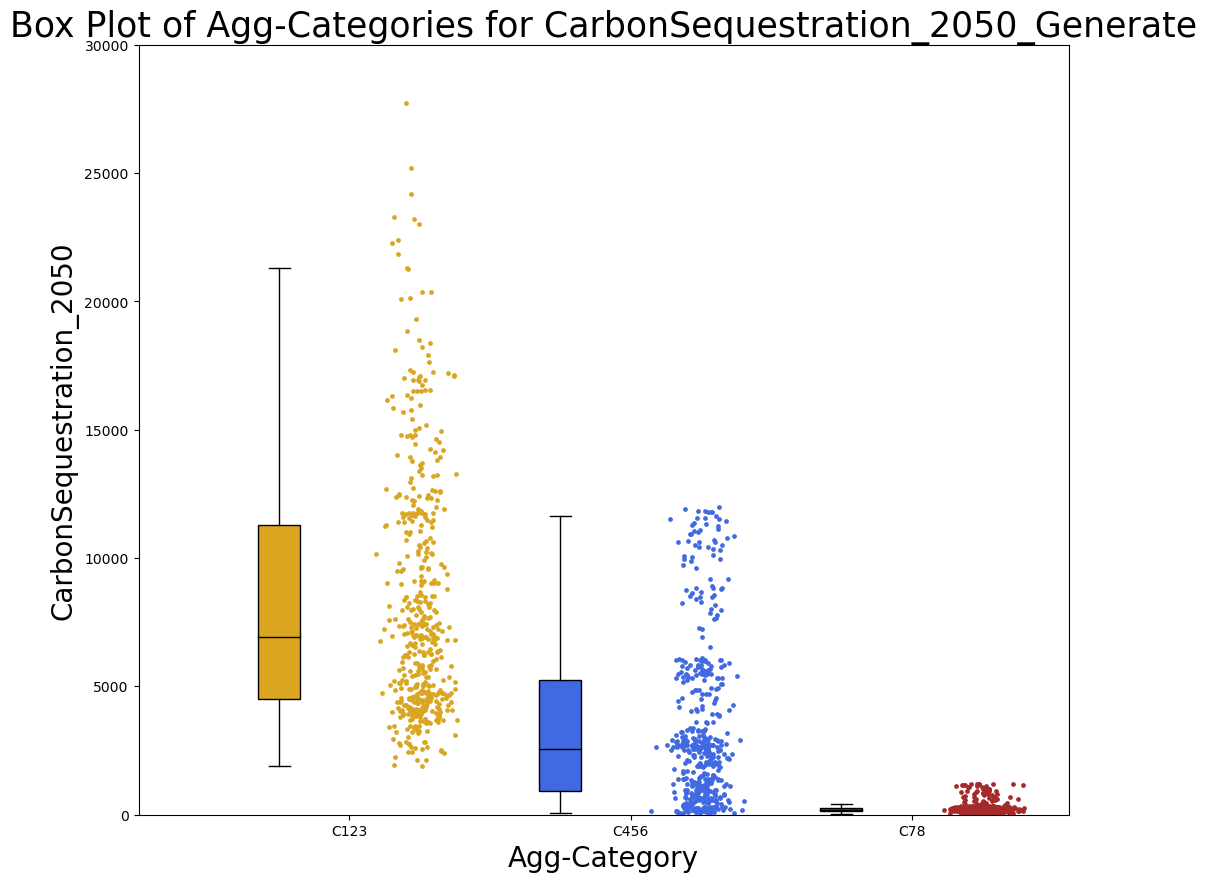

In [19]:
#CarbonSequestration_2050
import matplotlib.pyplot as plt
import seaborn as sns
Category_names = ['C123','C456','C78']
Data_Values = [Gen_C123[:,3,0],Gen_C456[:,3,0],Gen_C78[:,3,0]]
box_positions = np.arange(1, len(Category_names) + 1) - 0.25
scatter_positions = np.arange(1, len(Category_names) + 1) + 0.25

colors = ['goldenrod','royalblue','brown','orangered','olive','green','darkcyan','blueviolet']
plt.figure(figsize=(12,10))
box_plot = plt.boxplot(Data_Values,showfliers=False,patch_artist=True,widths=0.15,positions=box_positions)
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
for median_line in box_plot['medians']:
    median_line.set(color='black')
# scatterplot
for i, data in enumerate(Data_Values):
    x = np.random.normal(scatter_positions[i], 0.05, size=len(data))
    plt.scatter(x, data, color=colors[i], s=5.8)
plt.xlabel('Agg-Category',fontsize=20)
plt.ylabel('CarbonSequestration_2050',fontsize=20)
plt.title('Box Plot of Agg-Categories for CarbonSequestration_2050_Generate',fontsize=25)
# set scale
plt.xticks(range(1, len(Category_names) + 1), Category_names)
plt.ylim([0,30000])
#plt.savefig('Box Plot of Agg-Categories for CarbonSequestration_2050_Generate.pdf',format='pdf')
plt.show()

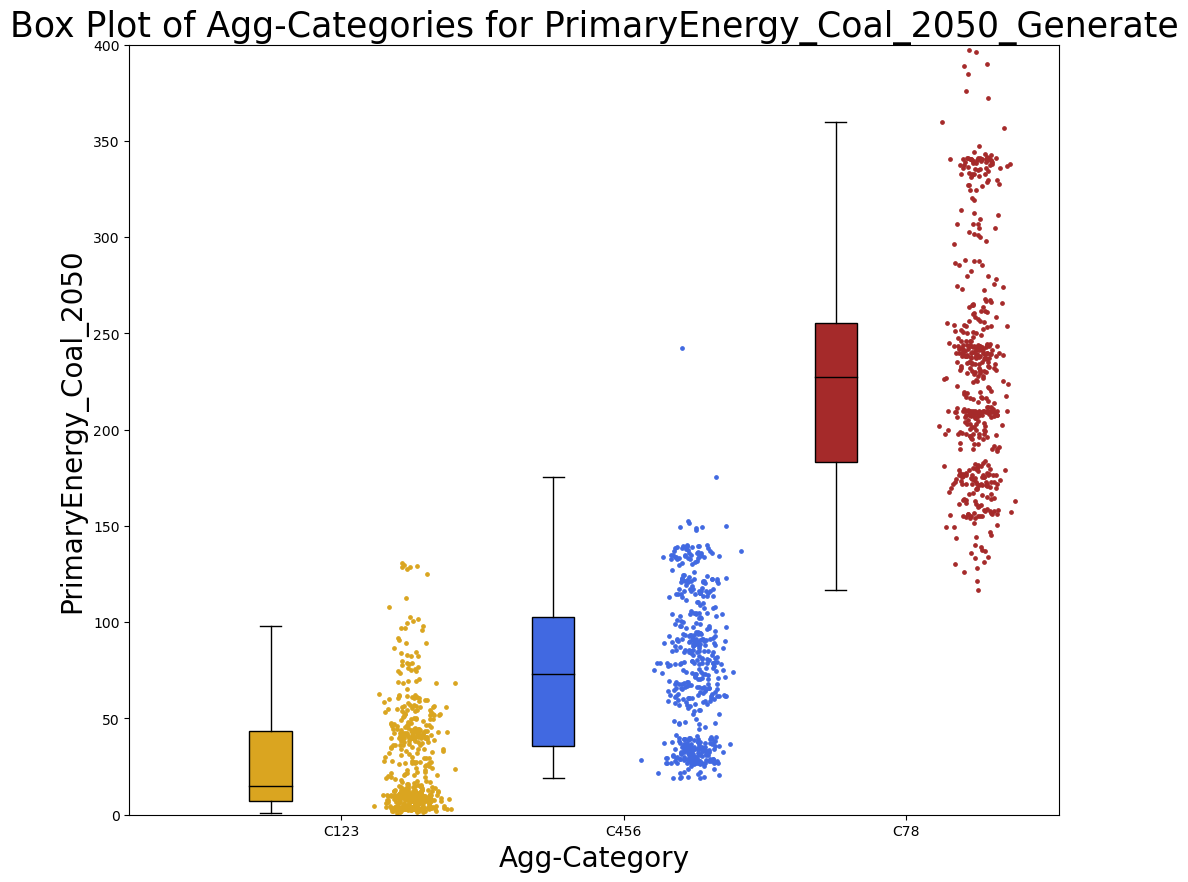

In [20]:
Data_Values = [Gen_C123[:,3,2],Gen_C456[:,3,2],Gen_C78[:,3,2]]
box_positions = np.arange(1, len(Category_names) + 1) - 0.25
scatter_positions = np.arange(1, len(Category_names) + 1) + 0.25
colors = ['goldenrod','royalblue','brown','orangered','olive','green','darkcyan','blueviolet']
plt.figure(figsize=(12,10))
box_plot = plt.boxplot(Data_Values,showfliers=False,patch_artist=True,widths=0.15,positions=box_positions)
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
for median_line in box_plot['medians']:
    median_line.set(color='black')
# scatterplot
for i, data in enumerate(Data_Values):
    x = np.random.normal(scatter_positions[i], 0.05, size=len(data))
    plt.scatter(x, data, color=colors[i], s=5.8)
plt.xlabel('Agg-Category',fontsize=20)
plt.ylabel('PrimaryEnergy_Coal_2050',fontsize=20)
plt.title('Box Plot of Agg-Categories for PrimaryEnergy_Coal_2050_Generate',fontsize=25)
# set scale
plt.xticks(range(1, len(Category_names) + 1), Category_names)
plt.ylim([0,400])
plt.savefig('Box Plot of Agg-Categories for PrimaryEnergy_Coal_2050_Generate.pdf',format='pdf')
plt.show()

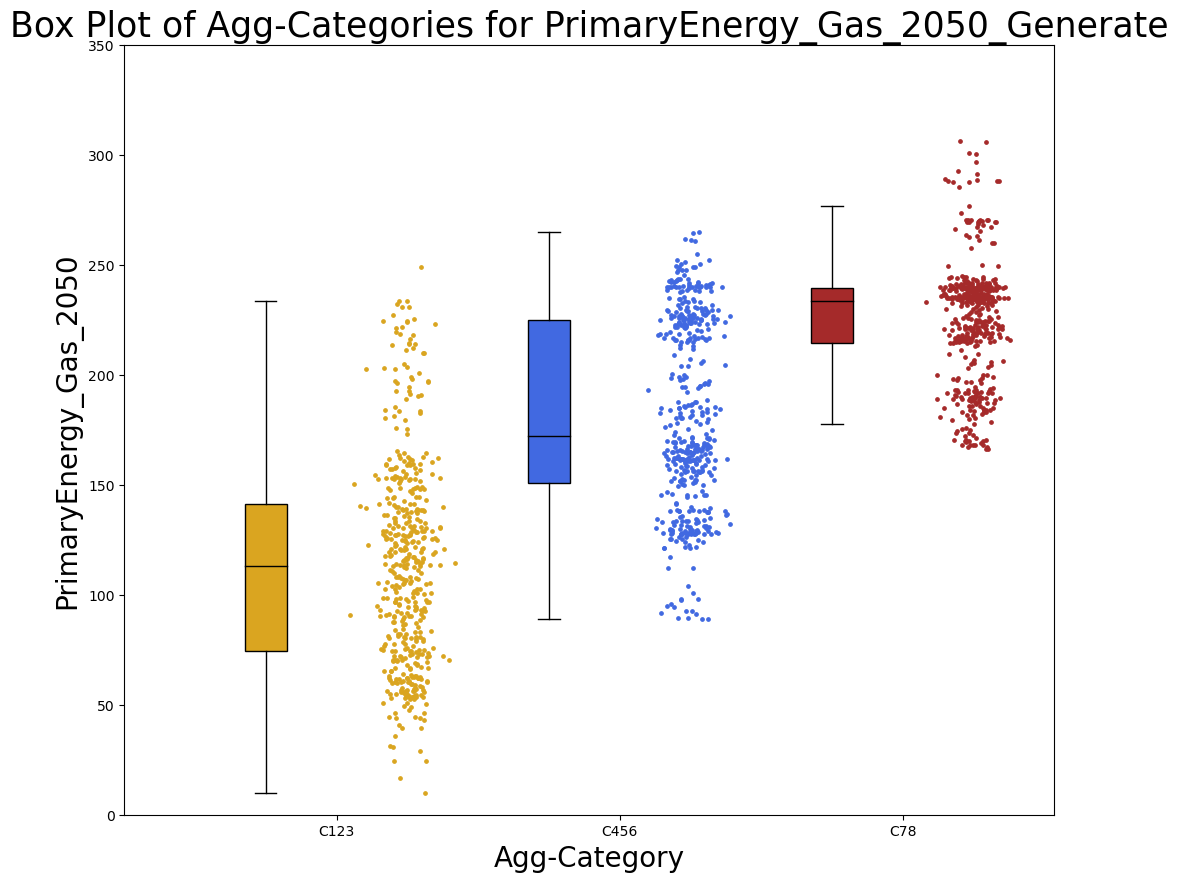

In [21]:
Data_Values = [Gen_C123[:,3,3],Gen_C456[:,3,3],Gen_C78[:,3,3]]
box_positions = np.arange(1, len(Category_names) + 1) - 0.25
scatter_positions = np.arange(1, len(Category_names) + 1) + 0.25
colors = ['goldenrod','royalblue','brown','orangered','olive','green','darkcyan','blueviolet']
plt.figure(figsize=(12,10))
box_plot = plt.boxplot(Data_Values,showfliers=False,patch_artist=True,widths=0.15,positions=box_positions)
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
for median_line in box_plot['medians']:
    median_line.set(color='black')
# scatterplot
for i, data in enumerate(Data_Values):
    x = np.random.normal(scatter_positions[i], 0.05, size=len(data))
    plt.scatter(x, data, color=colors[i], s=5.8)
plt.xlabel('Agg-Category',fontsize=20)
plt.ylabel('PrimaryEnergy_Gas_2050',fontsize=20)
plt.title('Box Plot of Agg-Categories for PrimaryEnergy_Gas_2050_Generate',fontsize=25)
# set scale
plt.xticks(range(1, len(Category_names) + 1), Category_names)
plt.ylim([0,350])
#plt.savefig('Box Plot of Agg-Categories for PrimaryEnergy_Gas_2050_Generate.pdf',format='pdf')
plt.show()

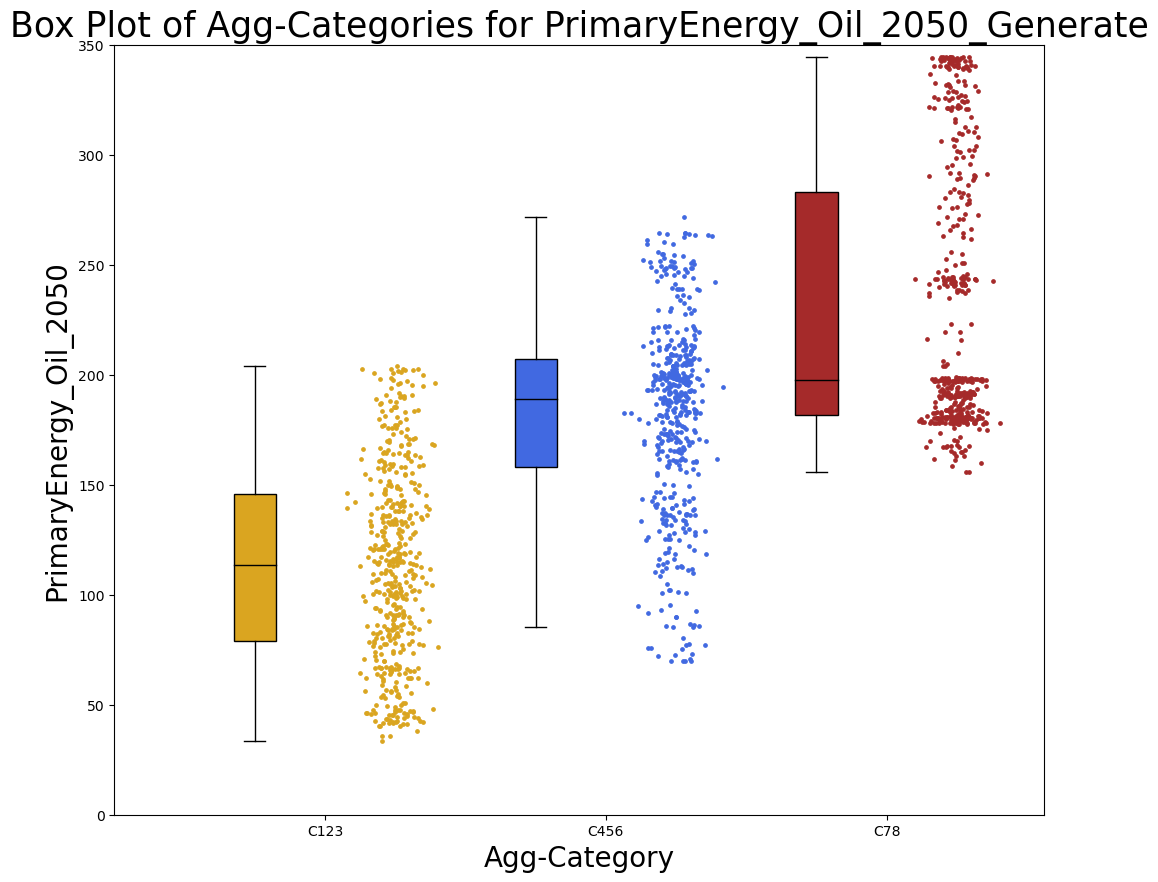

In [22]:
Data_Values = [Gen_C123[:,3,4],Gen_C456[:,3,4],Gen_C78[:,3,4]]
box_positions = np.arange(1, len(Category_names) + 1) - 0.25
scatter_positions = np.arange(1, len(Category_names) + 1) + 0.25
colors = ['goldenrod','royalblue','brown','orangered','olive','green','darkcyan','blueviolet']
plt.figure(figsize=(12,10))
box_plot = plt.boxplot(Data_Values,showfliers=False,patch_artist=True,widths=0.15,positions=box_positions)
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
for median_line in box_plot['medians']:
    median_line.set(color='black')
# scatterplot
for i, data in enumerate(Data_Values):
    x = np.random.normal(scatter_positions[i], 0.05, size=len(data))
    plt.scatter(x, data, color=colors[i], s=5.8)
plt.xlabel('Agg-Category',fontsize=20)
plt.ylabel('PrimaryEnergy_Oil_2050',fontsize=20)
plt.title('Box Plot of Agg-Categories for PrimaryEnergy_Oil_2050_Generate',fontsize=25)
# set scale
plt.xticks(range(1, len(Category_names) + 1), Category_names)
plt.ylim([0,350])
#plt.savefig('Box Plot of Agg-Categories for PrimaryEnergy_Oil_2050_Generate.pdf',format='pdf')
plt.show()

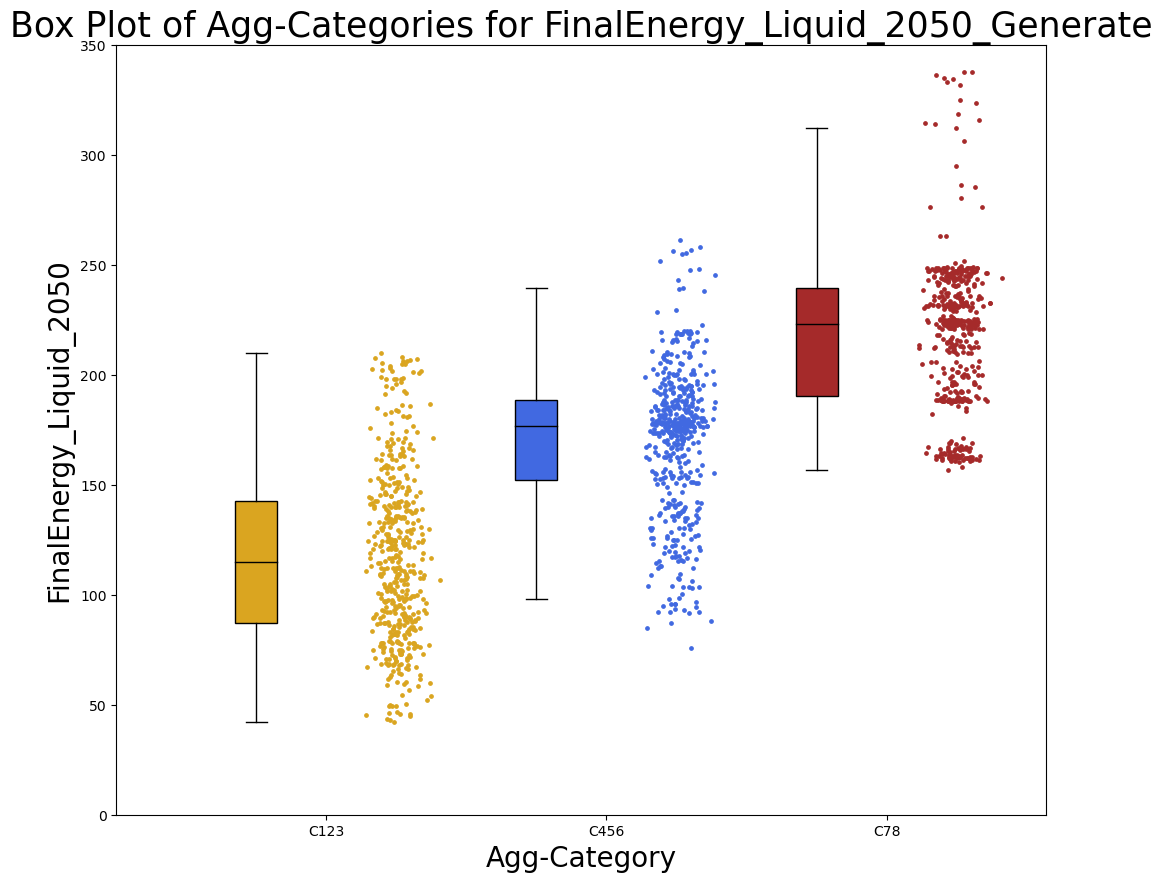

In [23]:
Data_Values = [Gen_C123[:,3,1],Gen_C456[:,3,1],Gen_C78[:,3,1]]
box_positions = np.arange(1, len(Category_names) + 1) - 0.25
scatter_positions = np.arange(1, len(Category_names) + 1) + 0.25
colors = ['goldenrod','royalblue','brown','orangered','olive','green','darkcyan','blueviolet']
plt.figure(figsize=(12,10))
box_plot = plt.boxplot(Data_Values,showfliers=False,patch_artist=True,widths=0.15,positions=box_positions)
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
for median_line in box_plot['medians']:
    median_line.set(color='black')
# scatterplot
for i, data in enumerate(Data_Values):
    x = np.random.normal(scatter_positions[i], 0.05, size=len(data))
    plt.scatter(x, data, color=colors[i], s=5.8)
plt.xlabel('Agg-Category',fontsize=20)
plt.ylabel('FinalEnergy_Liquid_2050',fontsize=20)
plt.title('Box Plot of Agg-Categories for FinalEnergy_Liquid_2050_Generate',fontsize=25)
# set scale
plt.xticks(range(1, len(Category_names) + 1), Category_names)
plt.ylim([0,350])
#plt.savefig('Box Plot of Agg-Categories for FinalEnergy_Liquid_2050_Generate.pdf',format='pdf')
plt.show()

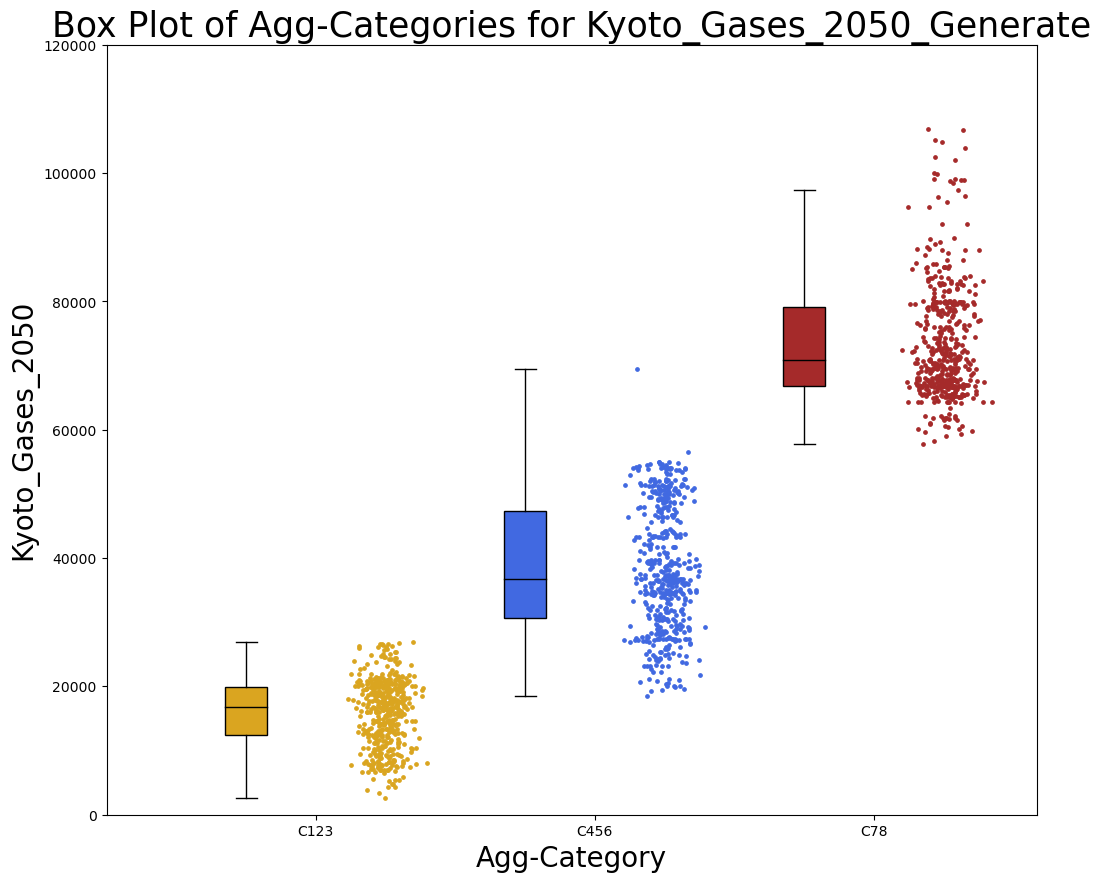

In [24]:
Data_Values = [Gen_C123[:,3,5],Gen_C456[:,3,5],Gen_C78[:,3,5]]
box_positions = np.arange(1, len(Category_names) + 1) - 0.25
scatter_positions = np.arange(1, len(Category_names) + 1) + 0.25
colors = ['goldenrod','royalblue','brown','orangered','olive','green','darkcyan','blueviolet']
plt.figure(figsize=(12,10))
box_plot = plt.boxplot(Data_Values,showfliers=False,patch_artist=True,widths=0.15,positions=box_positions)
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
for median_line in box_plot['medians']:
    median_line.set(color='black')
# scatterplot
for i, data in enumerate(Data_Values):
    x = np.random.normal(scatter_positions[i], 0.05, size=len(data))
    plt.scatter(x, data, color=colors[i], s=5.8)
plt.xlabel('Agg-Category',fontsize=20)
plt.ylabel('Kyoto_Gases_2050',fontsize=20)
plt.title('Box Plot of Agg-Categories for Kyoto_Gases_2050_Generate',fontsize=25)
# set scale
plt.xticks(range(1, len(Category_names) + 1), Category_names)
plt.ylim([0,120000])
#plt.savefig('Box Plot of Agg-Categories for Kyoto_Gases_2050_Generate.pdf',format='pdf')
plt.show()

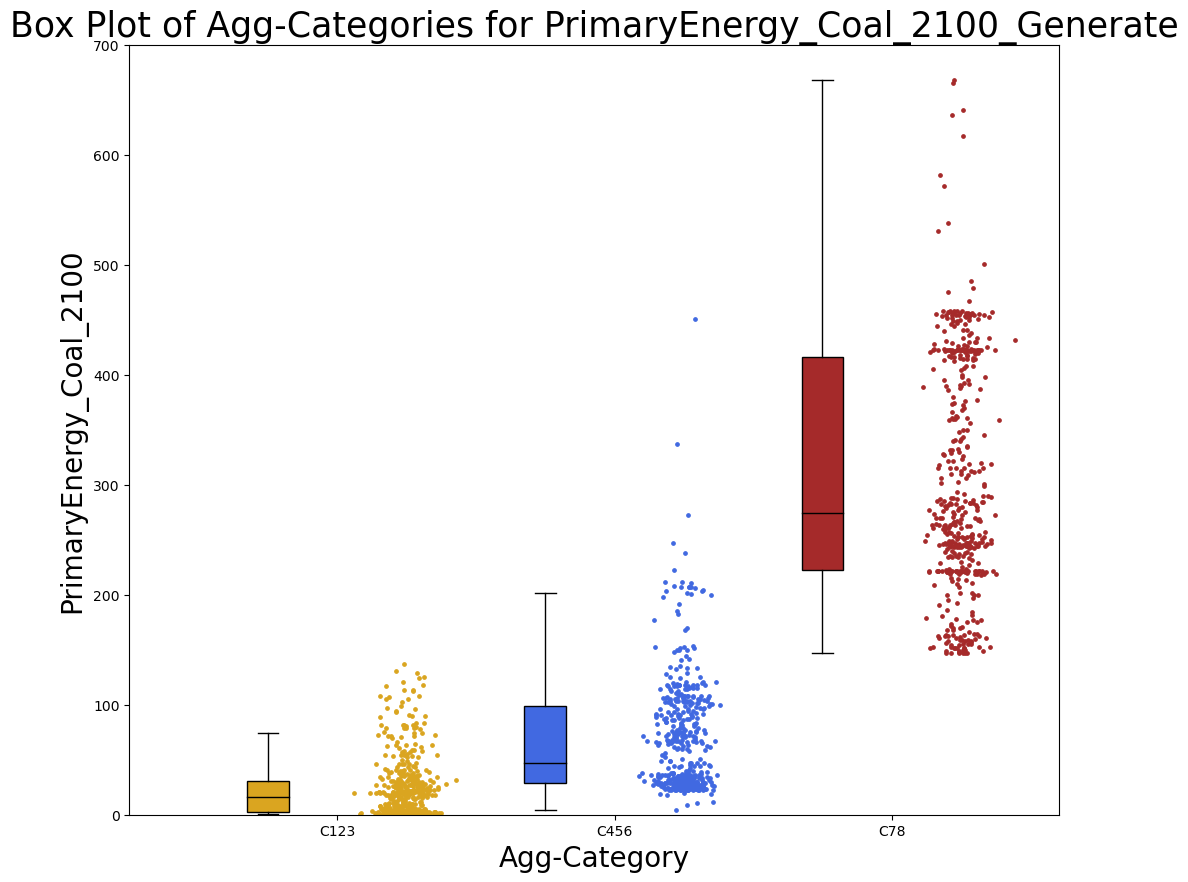

In [25]:
#PrimaryEnergy_Coal_2100
Data_Values = [Gen_C123[:,8,2],Gen_C456[:,8,2],Gen_C78[:,8,2]]
box_positions = np.arange(1, len(Category_names) + 1) - 0.25
scatter_positions = np.arange(1, len(Category_names) + 1) + 0.25

colors = ['goldenrod','royalblue','brown','orangered','olive','green','darkcyan','blueviolet']
plt.figure(figsize=(12,10))
box_plot = plt.boxplot(Data_Values,showfliers=False,patch_artist=True,widths=0.15,positions=box_positions)
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
for median_line in box_plot['medians']:
    median_line.set(color='black')
# scatterplot
for i, data in enumerate(Data_Values):
    x = np.random.normal(scatter_positions[i], 0.05, size=len(data))
    plt.scatter(x, data, color=colors[i], s=5.8)
plt.xlabel('Agg-Category',fontsize=20)
plt.ylabel('PrimaryEnergy_Coal_2100',fontsize=20)
plt.title('Box Plot of Agg-Categories for PrimaryEnergy_Coal_2100_Generate',fontsize=25)
# set scale
plt.xticks(range(1, len(Category_names) + 1), Category_names)
plt.ylim([0,700])
#plt.savefig('Box Plot of Agg-Categories for PrimaryEnergy_Coal_2100_Generate.pdf',format='pdf')
plt.show()

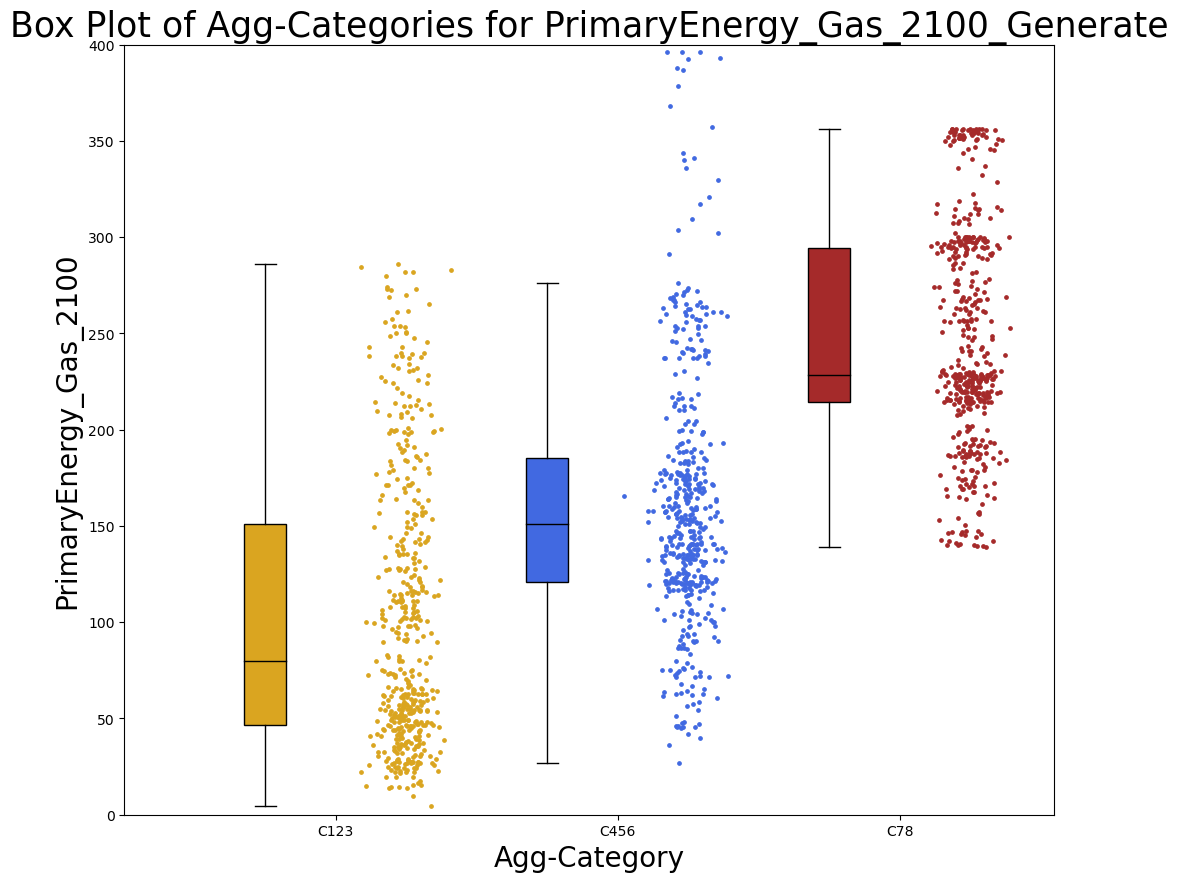

In [26]:
#PrimaryEnergy_Gas_2100
Data_Values = [Gen_C123[:,8,3],Gen_C456[:,8,3],Gen_C78[:,8,3]]
box_positions = np.arange(1, len(Category_names) + 1) - 0.25
scatter_positions = np.arange(1, len(Category_names) + 1) + 0.25

colors = ['goldenrod','royalblue','brown','orangered','olive','green','darkcyan','blueviolet']
plt.figure(figsize=(12,10))
box_plot = plt.boxplot(Data_Values,showfliers=False,patch_artist=True,widths=0.15,positions=box_positions)
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
for median_line in box_plot['medians']:
    median_line.set(color='black')
# scatterplot
for i, data in enumerate(Data_Values):
    x = np.random.normal(scatter_positions[i], 0.05, size=len(data))
    plt.scatter(x, data, color=colors[i], s=5.8)
plt.xlabel('Agg-Category',fontsize=20)
plt.ylabel('PrimaryEnergy_Gas_2100',fontsize=20)
plt.title('Box Plot of Agg-Categories for PrimaryEnergy_Gas_2100_Generate',fontsize=25)
# set scale
plt.xticks(range(1, len(Category_names) + 1), Category_names)
plt.ylim([0,400])
#plt.savefig('Box Plot of Agg-Categories for PrimaryEnergy_Gas_2100_Generate.pdf',format='pdf')
plt.show()

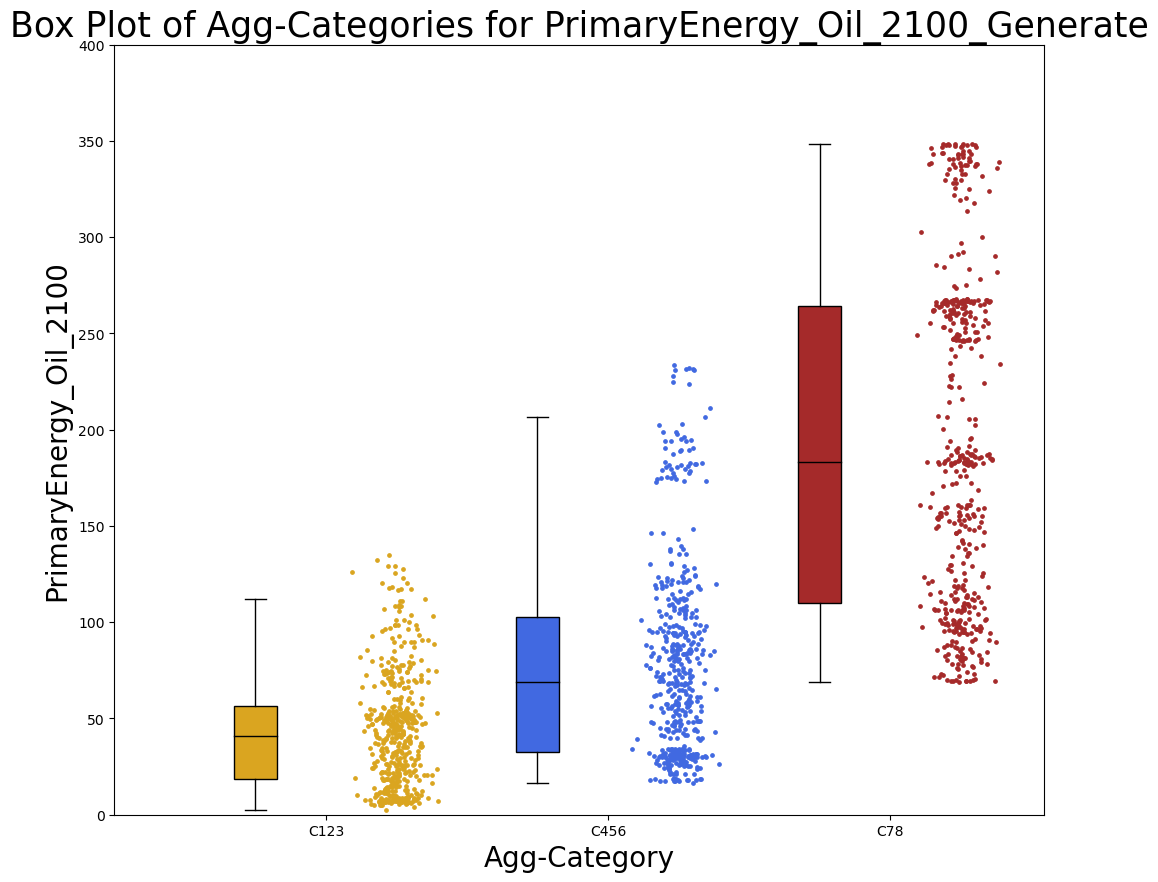

In [27]:
#PrimaryEnergy_Oil_2100
Data_Values = [Gen_C123[:,8,4],Gen_C456[:,8,4],Gen_C78[:,8,4]]
box_positions = np.arange(1, len(Category_names) + 1) - 0.25
scatter_positions = np.arange(1, len(Category_names) + 1) + 0.25

colors = ['goldenrod','royalblue','brown','orangered','olive','green','darkcyan','blueviolet']
plt.figure(figsize=(12,10))
box_plot = plt.boxplot(Data_Values,showfliers=False,patch_artist=True,widths=0.15,positions=box_positions)
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
for median_line in box_plot['medians']:
    median_line.set(color='black')
# scatterplot
for i, data in enumerate(Data_Values):
    x = np.random.normal(scatter_positions[i], 0.05, size=len(data))
    plt.scatter(x, data, color=colors[i], s=5.8)
plt.xlabel('Agg-Category',fontsize=20)
plt.ylabel('PrimaryEnergy_Oil_2100',fontsize=20)
plt.title('Box Plot of Agg-Categories for PrimaryEnergy_Oil_2100_Generate',fontsize=25)
# set scale
plt.xticks(range(1, len(Category_names) + 1), Category_names)
plt.ylim([0,400])
#plt.savefig('Box Plot of Agg-Categories for PrimaryEnergy_Oil_2100_Generate.pdf',format='pdf')
plt.show()

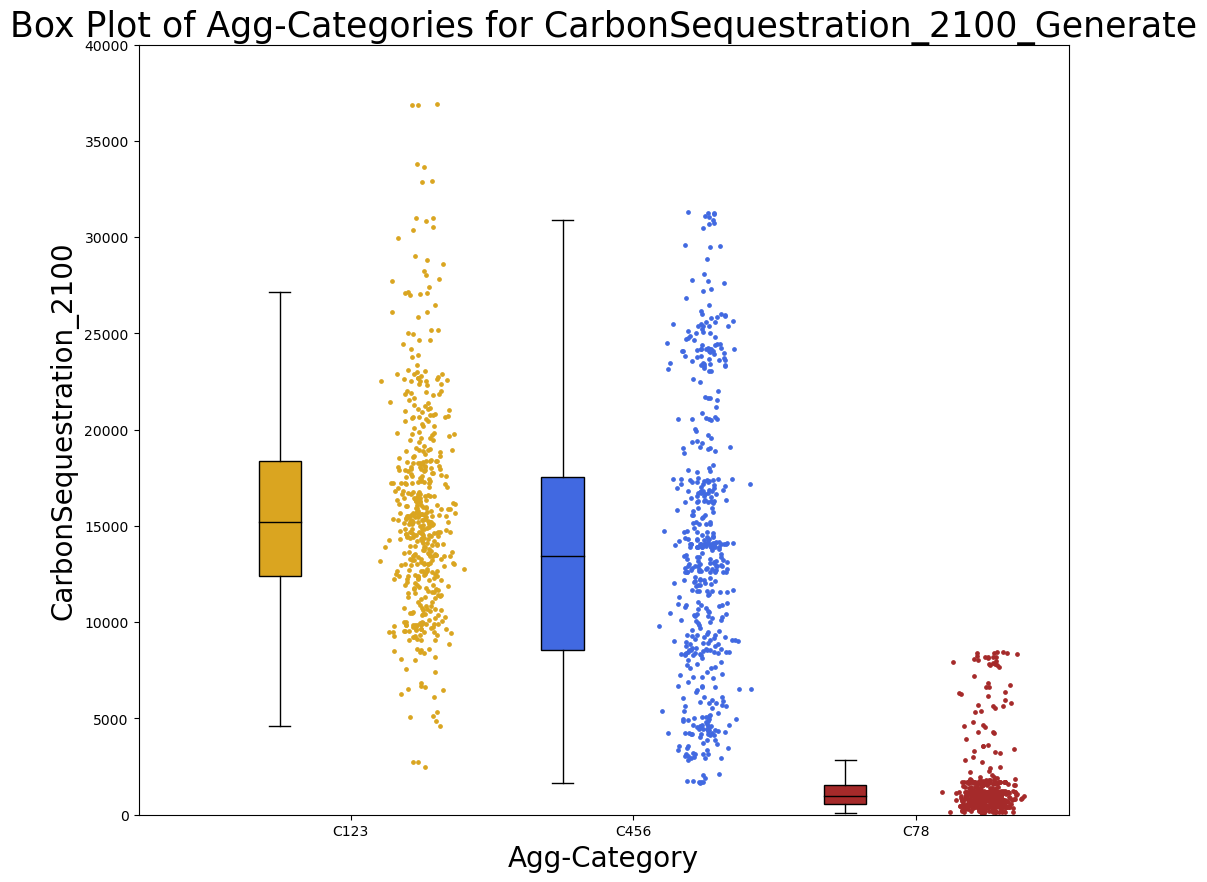

In [28]:
#CarbonSequestration_2100
Data_Values = [Gen_C123[:,8,0],Gen_C456[:,8,0],Gen_C78[:,8,0]]
box_positions = np.arange(1, len(Category_names) + 1) - 0.25
scatter_positions = np.arange(1, len(Category_names) + 1) + 0.25

colors = ['goldenrod','royalblue','brown','orangered','olive','green','darkcyan','blueviolet']
plt.figure(figsize=(12,10))
box_plot = plt.boxplot(Data_Values,showfliers=False,patch_artist=True,widths=0.15,positions=box_positions)
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
for median_line in box_plot['medians']:
    median_line.set(color='black')
# scatterplot
for i, data in enumerate(Data_Values):
    x = np.random.normal(scatter_positions[i], 0.05, size=len(data))
    plt.scatter(x, data, color=colors[i], s=5.8)
plt.xlabel('Agg-Category',fontsize=20)
plt.ylabel('CarbonSequestration_2100',fontsize=20)
plt.title('Box Plot of Agg-Categories for CarbonSequestration_2100_Generate',fontsize=25)
# set scale
plt.xticks(range(1, len(Category_names) + 1), Category_names)
plt.ylim([0,40000])
#plt.savefig('Box Plot of Agg-Categories for CarbonSequestration_2100_Generate.pdf',format='pdf')
plt.show()

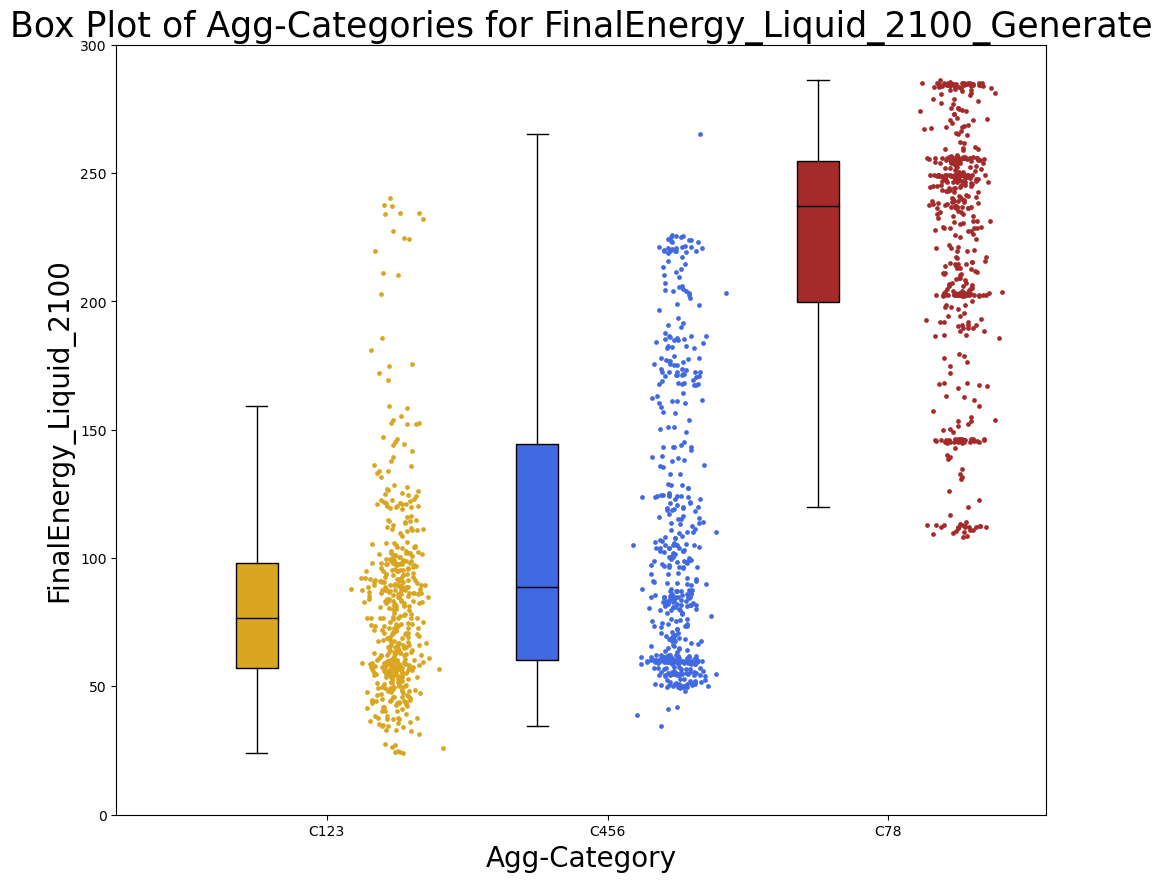

In [29]:
#FinalEnergy_Liquid_2100
Data_Values = [Gen_C123[:,8,1],Gen_C456[:,8,1],Gen_C78[:,8,1]]
box_positions = np.arange(1, len(Category_names) + 1) - 0.25
scatter_positions = np.arange(1, len(Category_names) + 1) + 0.25

colors = ['goldenrod','royalblue','brown','orangered','olive','green','darkcyan','blueviolet']
plt.figure(figsize=(12,10))
box_plot = plt.boxplot(Data_Values,showfliers=False,patch_artist=True,widths=0.15,positions=box_positions)
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
for median_line in box_plot['medians']:
    median_line.set(color='black')
# scatterplot
for i, data in enumerate(Data_Values):
    x = np.random.normal(scatter_positions[i], 0.05, size=len(data))
    plt.scatter(x, data, color=colors[i], s=5.8)
plt.xlabel('Agg-Category',fontsize=20)
plt.ylabel('FinalEnergy_Liquid_2100',fontsize=20)
plt.title('Box Plot of Agg-Categories for FinalEnergy_Liquid_2100_Generate',fontsize=25)
# set scale
plt.xticks(range(1, len(Category_names) + 1), Category_names)
plt.ylim([0,300])
#plt.savefig('Box Plot of Agg-Categories for FinalEnergy_Liquid_2100_Generate.pdf',format='pdf')
plt.show()

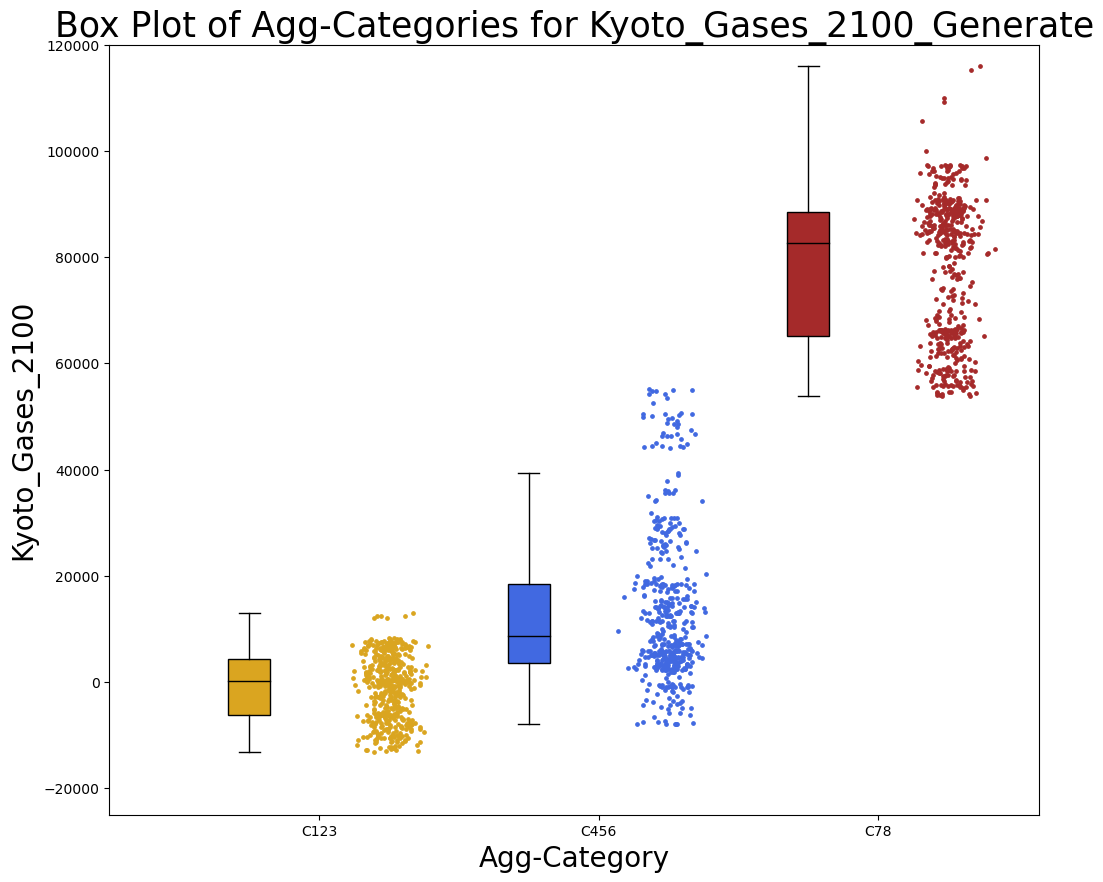

In [30]:
#Kyoto_Gases_2100
Data_Values = [Gen_C123[:,8,5],Gen_C456[:,8,5],Gen_C78[:,8,5]]
box_positions = np.arange(1, len(Category_names) + 1) - 0.25
scatter_positions = np.arange(1, len(Category_names) + 1) + 0.25

colors = ['goldenrod','royalblue','brown','orangered','olive','green','darkcyan','blueviolet']
plt.figure(figsize=(12,10))
box_plot = plt.boxplot(Data_Values,showfliers=False,patch_artist=True,widths=0.15,positions=box_positions)
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
for median_line in box_plot['medians']:
    median_line.set(color='black')
# scatterplot
for i, data in enumerate(Data_Values):
    x = np.random.normal(scatter_positions[i], 0.05, size=len(data))
    plt.scatter(x, data, color=colors[i], s=5.8)
plt.xlabel('Agg-Category',fontsize=20)
plt.ylabel('Kyoto_Gases_2100',fontsize=20)
plt.title('Box Plot of Agg-Categories for Kyoto_Gases_2100_Generate',fontsize=25)
# set scale
plt.xticks(range(1, len(Category_names) + 1), Category_names)
plt.ylim([-25000,120000])
#plt.savefig('Box Plot of Agg-Categories for Kyoto_Gases_2100_Generate.pdf',format='pdf')
plt.show()

In [31]:
Gen_Data = np.concatenate((Gen_C123,Gen_C456,Gen_C78),axis=0)
Gen_Labels = np.zeros(1500)
Gen_Labels[500:1000] = 1
Gen_Labels[1000:] = 2

In [32]:
#Extract the true CarbonSequestration value of each model-scene at 2050 (Agg-Category)
CarbonSequestration_2050 = pd.DataFrame({'2050':X[:,3,0],'Category':Y})
C123_CarbonSequestration_2050 = CarbonSequestration_2050[CarbonSequestration_2050['Category']== 0]['2050'].values
C456_CarbonSequestration_2050 = CarbonSequestration_2050[CarbonSequestration_2050['Category']== 1]['2050'].values
C78_CarbonSequestration_2050 = CarbonSequestration_2050[CarbonSequestration_2050['Category']== 2]['2050'].values

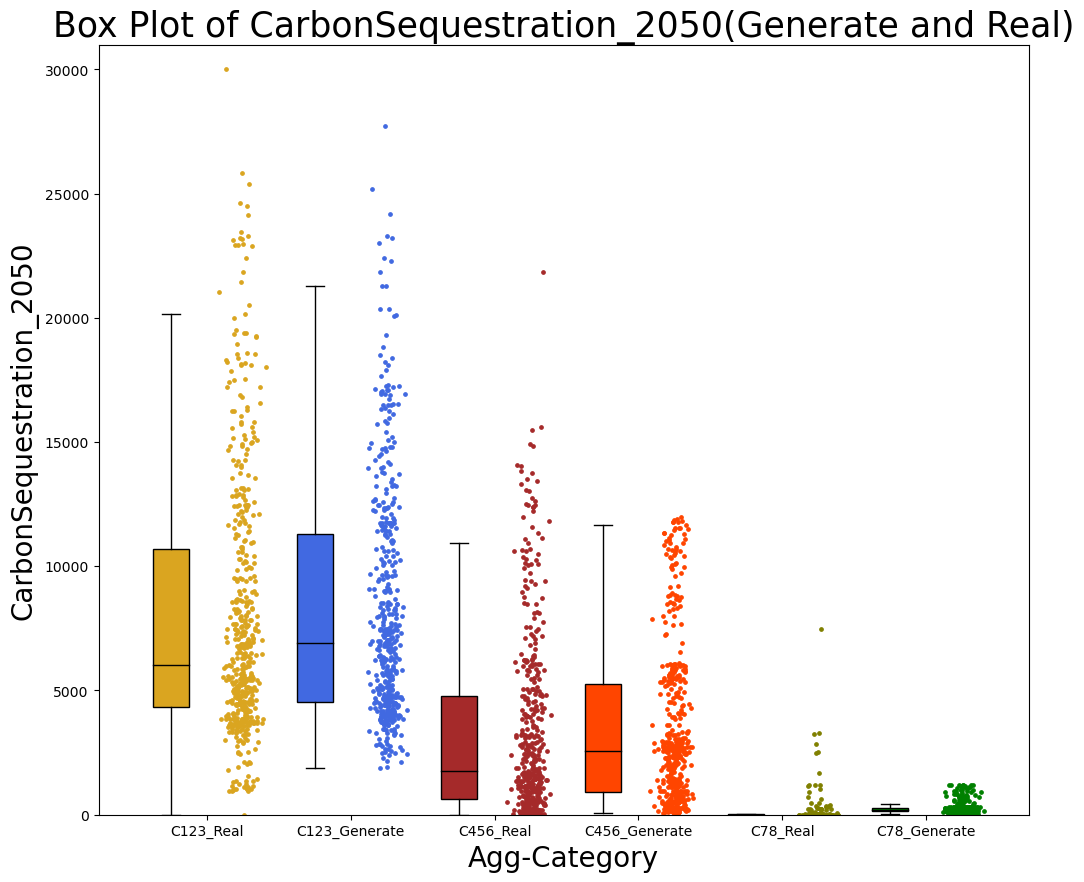

In [33]:
#CarbonSequestration_2050 real data versus generated data.
Category_names = ['C123_Real','C123_Generate','C456_Real','C456_Generate','C78_Real','C78_Generate']
Data_Values = [C123_CarbonSequestration_2050,Gen_C123[:,3,0],C456_CarbonSequestration_2050,Gen_C456[:,3,0],C78_CarbonSequestration_2050,Gen_C78[:,3,0]]
box_positions = np.arange(1, len(Category_names) + 1) - 0.25
scatter_positions = np.arange(1, len(Category_names) + 1) + 0.25

colors = ['goldenrod','royalblue','brown','orangered','olive','green','darkcyan','blueviolet']
plt.figure(figsize=(12,10))
box_plot = plt.boxplot(Data_Values,showfliers=False,patch_artist=True,widths=0.25,positions=box_positions)
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
for median_line in box_plot['medians']:
    median_line.set(color='black')
# scatterplot
for i, data in enumerate(Data_Values):
    x = np.random.normal(scatter_positions[i], 0.05, size=len(data))
    plt.scatter(x, data, color=colors[i], s=5.8)
plt.xlabel('Agg-Category',fontsize=20)
plt.ylabel('CarbonSequestration_2050',fontsize=20)
plt.title('Box Plot of CarbonSequestration_2050(Generate and Real)',fontsize=25)
# set scale
plt.xticks(range(1, len(Category_names) + 1), Category_names)
plt.ylim([0,31000])
#plt.savefig('Box Plot of CarbonSequestration_2050(Generate and Real).pdf',format='pdf')
plt.show()

In [34]:
FinalEnergy_Liquid_2050 = pd.DataFrame({'2050':X[:,3,1],'Category':Y})
C123_FinalEnergy_Liquid_2050 = FinalEnergy_Liquid_2050[FinalEnergy_Liquid_2050['Category']== 0]['2050'].values
C456_FinalEnergy_Liquid_2050 = FinalEnergy_Liquid_2050[FinalEnergy_Liquid_2050['Category']== 1]['2050'].values
C78_FinalEnergy_Liquid_2050 = FinalEnergy_Liquid_2050[FinalEnergy_Liquid_2050['Category']== 2]['2050'].values

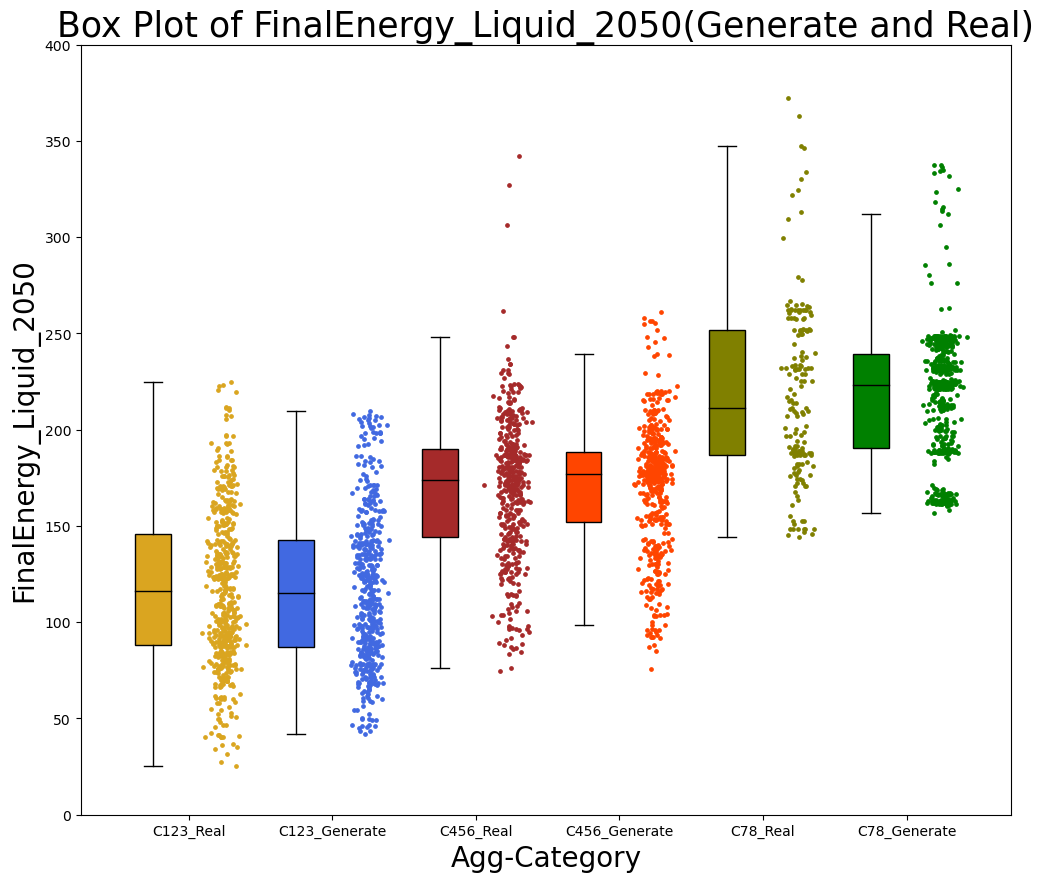

In [35]:
#FinalEnergy_Liquid_2050 real data versus generated data.
Category_names = ['C123_Real','C123_Generate','C456_Real','C456_Generate','C78_Real','C78_Generate']
Data_Values = [C123_FinalEnergy_Liquid_2050,Gen_C123[:,3,1],C456_FinalEnergy_Liquid_2050,Gen_C456[:,3,1],C78_FinalEnergy_Liquid_2050,Gen_C78[:,3,1]]
box_positions = np.arange(1, len(Category_names) + 1) - 0.25
scatter_positions = np.arange(1, len(Category_names) + 1) + 0.25

colors = ['goldenrod','royalblue','brown','orangered','olive','green','darkcyan','blueviolet']
plt.figure(figsize=(12,10))
box_plot = plt.boxplot(Data_Values,showfliers=False,patch_artist=True,widths=0.25,positions=box_positions)
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
for median_line in box_plot['medians']:
    median_line.set(color='black')
# scatterplot
for i, data in enumerate(Data_Values):
    x = np.random.normal(scatter_positions[i], 0.05, size=len(data))
    plt.scatter(x, data, color=colors[i], s=5.8)
plt.xlabel('Agg-Category',fontsize=20)
plt.ylabel('FinalEnergy_Liquid_2050',fontsize=20)
plt.title('Box Plot of FinalEnergy_Liquid_2050(Generate and Real)',fontsize=25)
# set scale
plt.xticks(range(1, len(Category_names) + 1), Category_names)
plt.ylim([0,400])
#plt.savefig('Box Plot of FinalEnergy_Liquid_2050(Generate and Real).pdf',format='pdf')
plt.show()

In [36]:
PrimaryEnergy_Coal_2050 = pd.DataFrame({'2050':X[:,3,2],'Category':Y})
C123_PrimaryEnergy_Coal_2050 = PrimaryEnergy_Coal_2050[PrimaryEnergy_Coal_2050['Category']== 0]['2050'].values
C456_PrimaryEnergy_Coal_2050 = PrimaryEnergy_Coal_2050[PrimaryEnergy_Coal_2050['Category']== 1]['2050'].values
C78_PrimaryEnergy_Coal_2050 = PrimaryEnergy_Coal_2050[PrimaryEnergy_Coal_2050['Category']== 2]['2050'].values

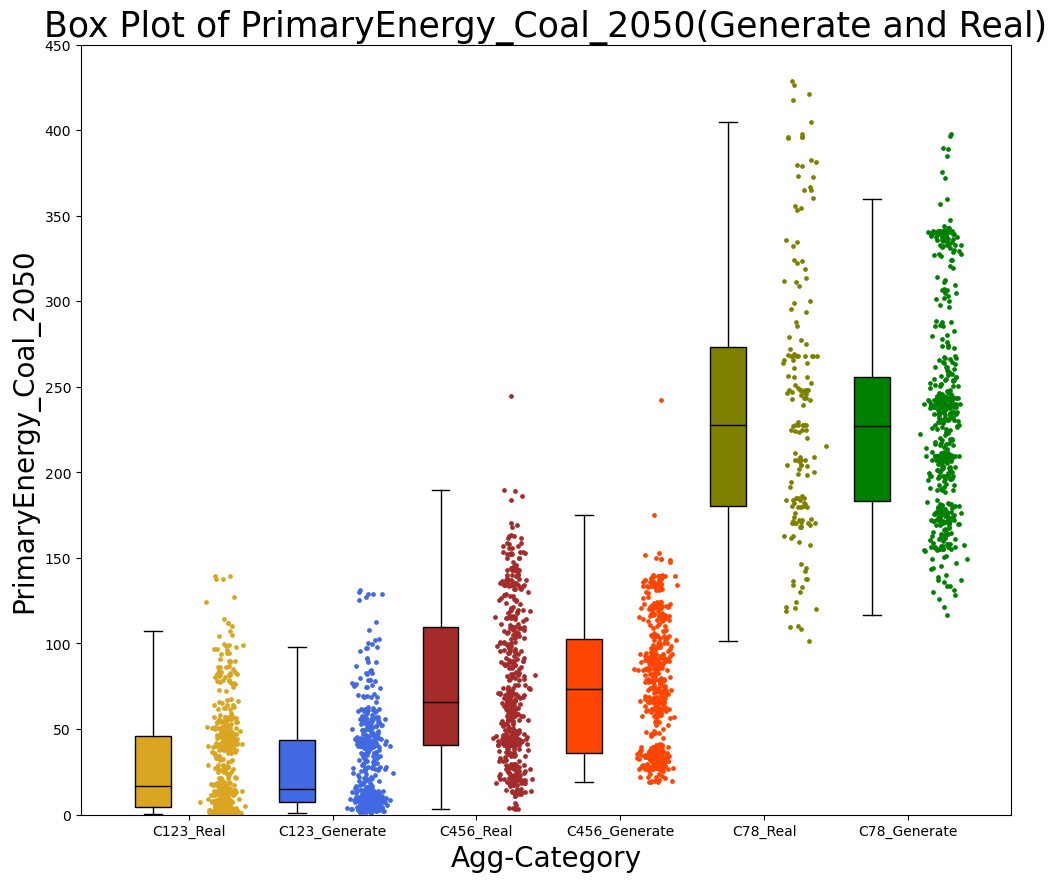

In [37]:
#PrimaryEnergy_Coal_2050 real data versus generated data.
Category_names = ['C123_Real','C123_Generate','C456_Real','C456_Generate','C78_Real','C78_Generate']
Data_Values = [C123_PrimaryEnergy_Coal_2050,Gen_C123[:,3,2],C456_PrimaryEnergy_Coal_2050,Gen_C456[:,3,2],C78_PrimaryEnergy_Coal_2050,Gen_C78[:,3,2]]
box_positions = np.arange(1, len(Category_names) + 1) - 0.25
scatter_positions = np.arange(1, len(Category_names) + 1) + 0.25

colors = ['goldenrod','royalblue','brown','orangered','olive','green','darkcyan','blueviolet']
plt.figure(figsize=(12,10))
box_plot = plt.boxplot(Data_Values,showfliers=False,patch_artist=True,widths=0.25,positions=box_positions)
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
for median_line in box_plot['medians']:
    median_line.set(color='black')
# scatterplot
for i, data in enumerate(Data_Values):
    x = np.random.normal(scatter_positions[i], 0.05, size=len(data))
    plt.scatter(x, data, color=colors[i], s=5.8)
plt.xlabel('Agg-Category',fontsize=20)
plt.ylabel('PrimaryEnergy_Coal_2050',fontsize=20)
plt.title('Box Plot of PrimaryEnergy_Coal_2050(Generate and Real)',fontsize=25)
# set scale
plt.xticks(range(1, len(Category_names) + 1), Category_names)
plt.ylim([0,450])
#plt.savefig('Box Plot of PrimaryEnergy_Coal_2050(Generate and Real).pdf',format='pdf')
plt.show()

In [38]:
PrimaryEnergy_Gas_2050 = pd.DataFrame({'2050':X[:,3,3],'Category':Y})
C123_PrimaryEnergy_Gas_2050 = PrimaryEnergy_Gas_2050[PrimaryEnergy_Gas_2050['Category']== 0]['2050'].values
C456_PrimaryEnergy_Gas_2050 = PrimaryEnergy_Gas_2050[PrimaryEnergy_Gas_2050['Category']== 1]['2050'].values
C78_PrimaryEnergy_Gas_2050 = PrimaryEnergy_Gas_2050[PrimaryEnergy_Gas_2050['Category']== 2]['2050'].values

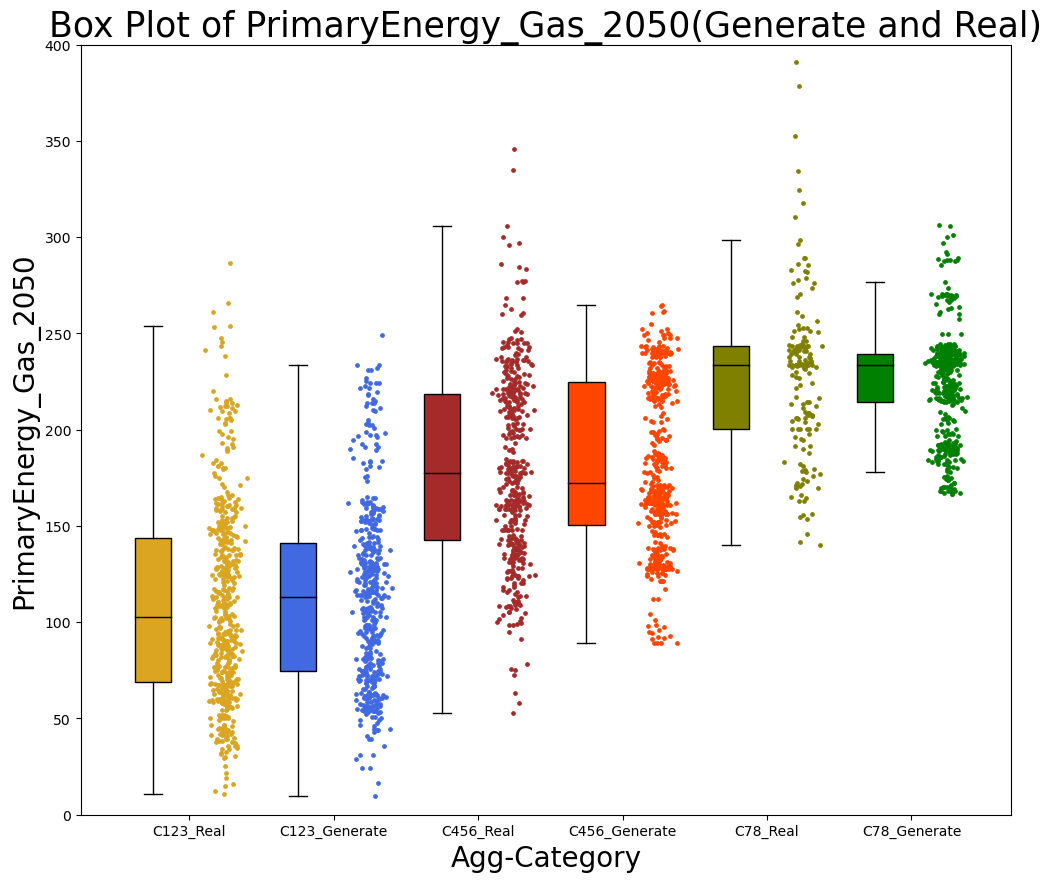

In [39]:
#PrimaryEnergy_Gas_2050 real data versus generated data.
Category_names = ['C123_Real','C123_Generate','C456_Real','C456_Generate','C78_Real','C78_Generate']
Data_Values = [C123_PrimaryEnergy_Gas_2050,Gen_C123[:,3,3],C456_PrimaryEnergy_Gas_2050,Gen_C456[:,3,3],C78_PrimaryEnergy_Gas_2050,Gen_C78[:,3,3]]
box_positions = np.arange(1, len(Category_names) + 1) - 0.25
scatter_positions = np.arange(1, len(Category_names) + 1) + 0.25

colors = ['goldenrod','royalblue','brown','orangered','olive','green','darkcyan','blueviolet']
plt.figure(figsize=(12,10))
box_plot = plt.boxplot(Data_Values,showfliers=False,patch_artist=True,widths=0.25,positions=box_positions)
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
for median_line in box_plot['medians']:
    median_line.set(color='black')
# scatterplot
for i, data in enumerate(Data_Values):
    x = np.random.normal(scatter_positions[i], 0.05, size=len(data))
    plt.scatter(x, data, color=colors[i], s=5.8)
plt.xlabel('Agg-Category',fontsize=20)
plt.ylabel('PrimaryEnergy_Gas_2050',fontsize=20)
plt.title('Box Plot of PrimaryEnergy_Gas_2050(Generate and Real)',fontsize=25)
# set scale
plt.xticks(range(1, len(Category_names) + 1), Category_names)
plt.ylim([0,400])
#plt.savefig('Box Plot of PrimaryEnergy_Gas_2050(Generate and Real).pdf',format='pdf')
plt.show()

In [40]:
PrimaryEnergy_Oil_2050 = pd.DataFrame({'2050':X[:,3,4],'Category':Y})
C123_PrimaryEnergy_Oil_2050 = PrimaryEnergy_Oil_2050[PrimaryEnergy_Oil_2050['Category']== 0]['2050'].values
C456_PrimaryEnergy_Oil_2050 = PrimaryEnergy_Oil_2050[PrimaryEnergy_Oil_2050['Category']== 1]['2050'].values
C78_PrimaryEnergy_Oil_2050 = PrimaryEnergy_Oil_2050[PrimaryEnergy_Oil_2050['Category']== 2]['2050'].values

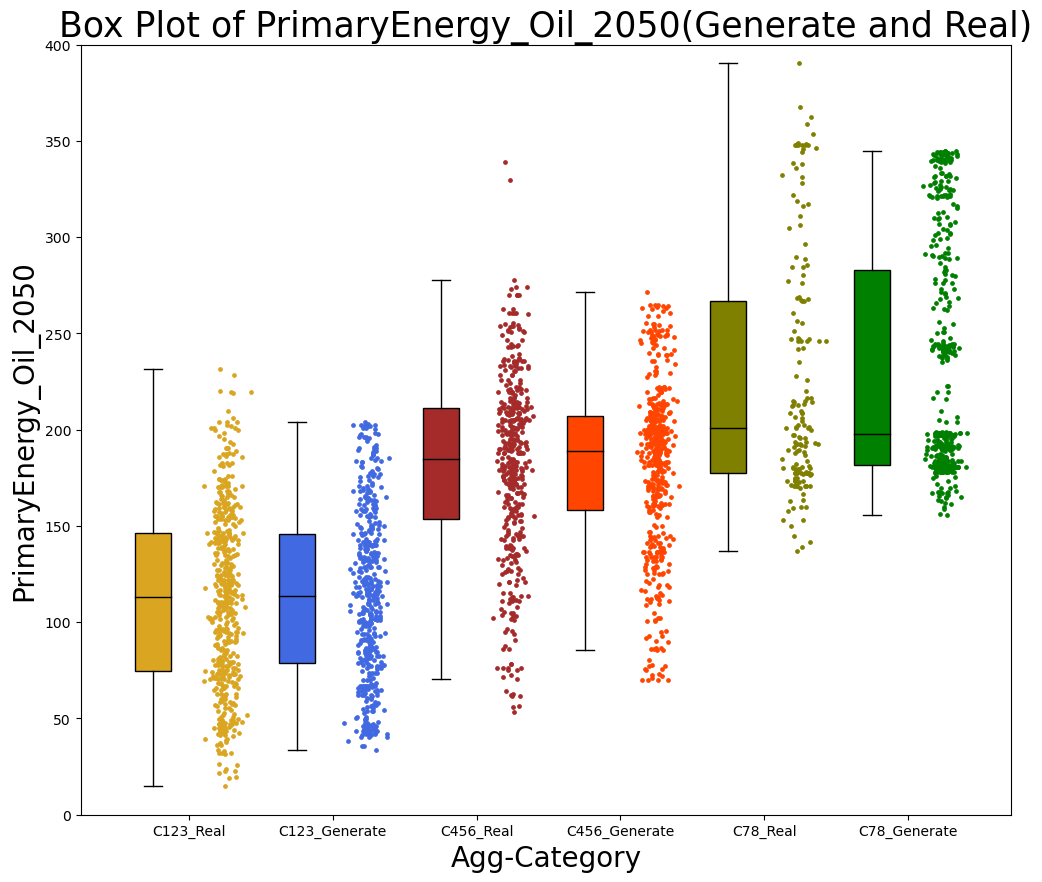

In [41]:
#PrimaryEnergy_Oil_2050 real data versus generated data.
Category_names = ['C123_Real','C123_Generate','C456_Real','C456_Generate','C78_Real','C78_Generate']
Data_Values = [C123_PrimaryEnergy_Oil_2050,Gen_C123[:,3,4],C456_PrimaryEnergy_Oil_2050,Gen_C456[:,3,4],C78_PrimaryEnergy_Oil_2050,Gen_C78[:,3,4]]
box_positions = np.arange(1, len(Category_names) + 1) - 0.25
scatter_positions = np.arange(1, len(Category_names) + 1) + 0.25

colors = ['goldenrod','royalblue','brown','orangered','olive','green','darkcyan','blueviolet']
plt.figure(figsize=(12,10))
box_plot = plt.boxplot(Data_Values,showfliers=False,patch_artist=True,widths=0.25,positions=box_positions)
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
for median_line in box_plot['medians']:
    median_line.set(color='black')
# scatterplot
for i, data in enumerate(Data_Values):
    x = np.random.normal(scatter_positions[i], 0.05, size=len(data))
    plt.scatter(x, data, color=colors[i], s=5.8)
plt.xlabel('Agg-Category',fontsize=20)
plt.ylabel('PrimaryEnergy_Oil_2050',fontsize=20)
plt.title('Box Plot of PrimaryEnergy_Oil_2050(Generate and Real)',fontsize=25)
# set scale
plt.xticks(range(1, len(Category_names) + 1), Category_names)
plt.ylim([0,400])
#plt.savefig('Box Plot of PrimaryEnergy_Oil_2050(Generate and Real).pdf',format='pdf')
plt.show()

In [42]:
Kyoto_Gases_2050 = pd.DataFrame({'2050':X[:,3,5],'Category':Y})
C123_Kyoto_Gases_2050 = Kyoto_Gases_2050[Kyoto_Gases_2050['Category']== 0]['2050'].values
C456_Kyoto_Gases_2050 = Kyoto_Gases_2050[Kyoto_Gases_2050['Category']== 1]['2050'].values
C78_Kyoto_Gases_2050 = Kyoto_Gases_2050[Kyoto_Gases_2050['Category']== 2]['2050'].values

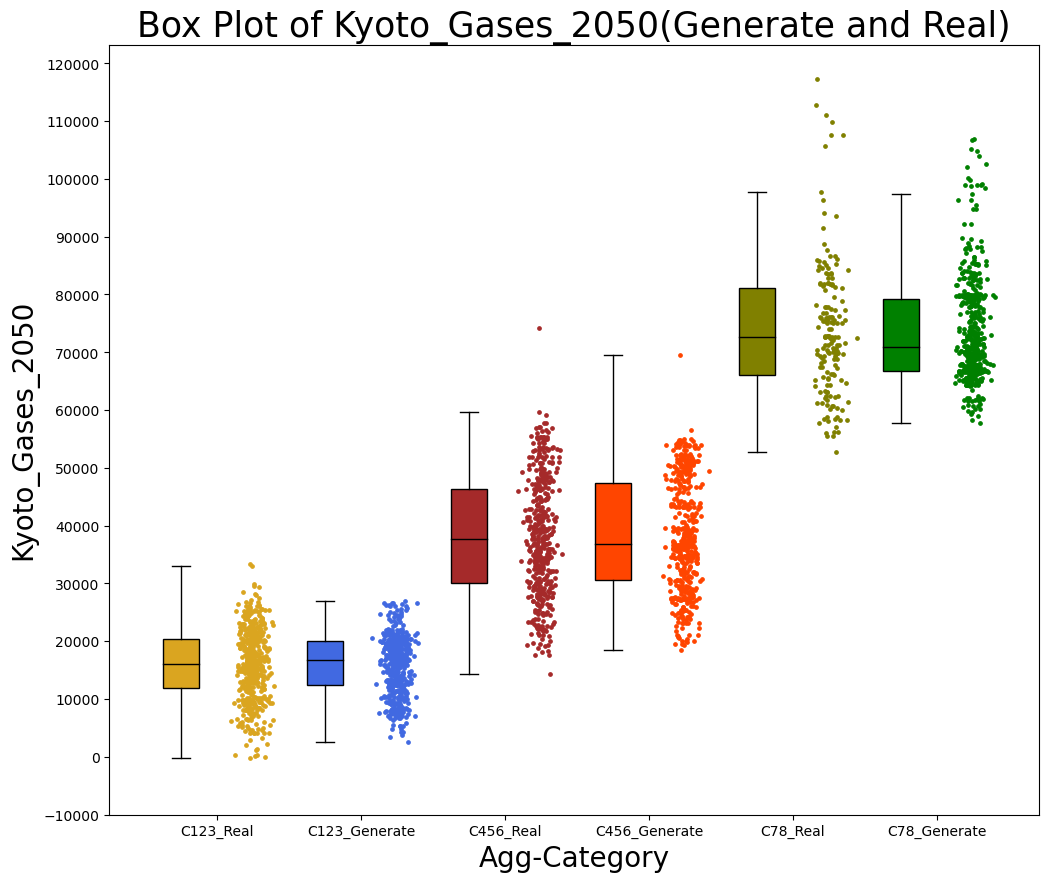

In [43]:
#Kyoto_Gases_2050 real data versus generated data.
Category_names = ['C123_Real','C123_Generate','C456_Real','C456_Generate','C78_Real','C78_Generate']
Data_Values = [C123_Kyoto_Gases_2050,Gen_C123[:,3,5],C456_Kyoto_Gases_2050,Gen_C456[:,3,5],C78_Kyoto_Gases_2050,Gen_C78[:,3,5]]
box_positions = np.arange(1, len(Category_names) + 1) - 0.25
scatter_positions = np.arange(1, len(Category_names) + 1) + 0.25

colors = ['goldenrod','royalblue','brown','orangered','olive','green','darkcyan','blueviolet']
plt.figure(figsize=(12,10))
box_plot = plt.boxplot(Data_Values,showfliers=False,patch_artist=True,widths=0.25,positions=box_positions)
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
for median_line in box_plot['medians']:
    median_line.set(color='black')
# scatterplot
for i, data in enumerate(Data_Values):
    x = np.random.normal(scatter_positions[i], 0.05, size=len(data))
    plt.scatter(x, data, color=colors[i], s=5.8)
plt.xlabel('Agg-Category',fontsize=20)
plt.ylabel('Kyoto_Gases_2050',fontsize=20)
plt.title('Box Plot of Kyoto_Gases_2050(Generate and Real)',fontsize=25)
# set scale
plt.xticks(range(1, len(Category_names) + 1), Category_names)
plt.yticks(np.arange(-10000,120001,10000))
#plt.savefig('Box Plot of Kyoto_Gases_2050(Generate and Real).pdf',format='pdf')
plt.show()

In [44]:
CarbonSequestration_2100 = pd.DataFrame({'2100':X[:,8,0],'Category':Y})
C123_CarbonSequestration_2100 = CarbonSequestration_2100[CarbonSequestration_2100['Category']== 0]['2100'].values
C456_CarbonSequestration_2100 = CarbonSequestration_2100[CarbonSequestration_2100['Category']== 1]['2100'].values
C78_CarbonSequestration_2100 = CarbonSequestration_2100[CarbonSequestration_2100['Category']== 2]['2100'].values

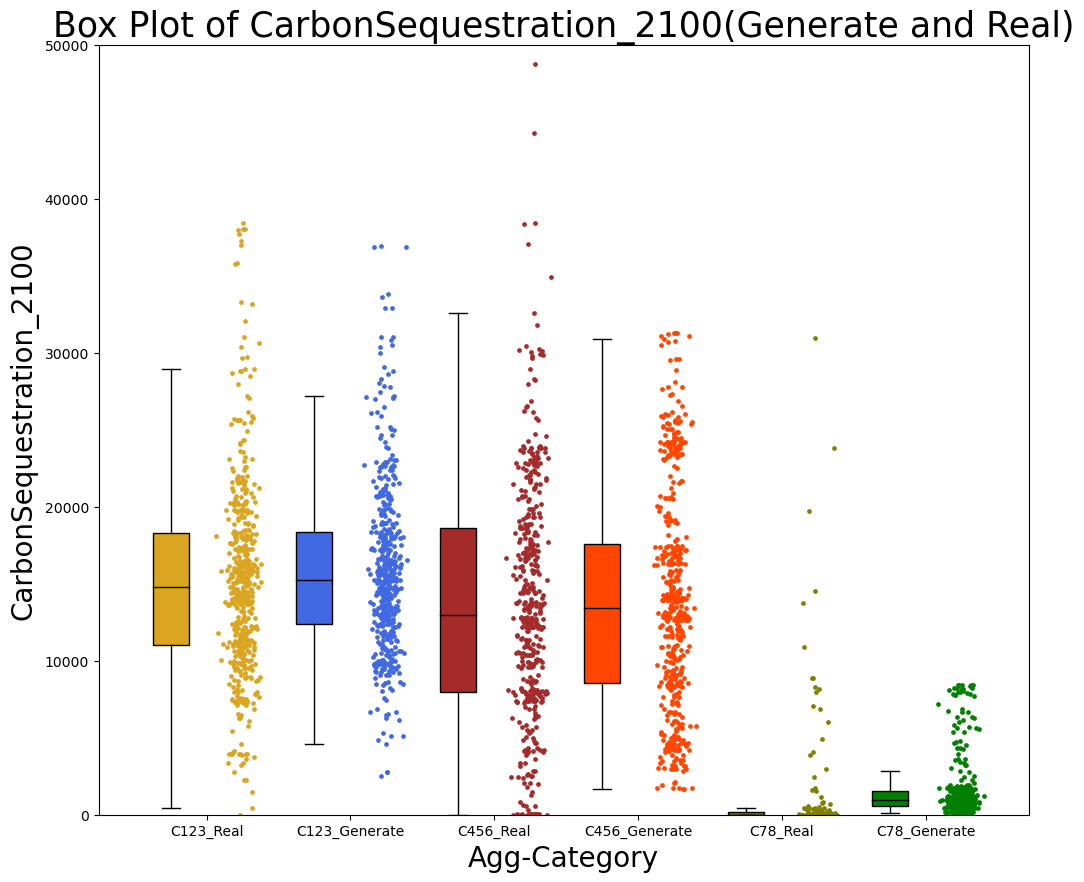

In [45]:
#CarbonSequestration_2100 real data versus generated data.
Category_names = ['C123_Real','C123_Generate','C456_Real','C456_Generate','C78_Real','C78_Generate']
Data_Values = [C123_CarbonSequestration_2100,Gen_C123[:,8,0],C456_CarbonSequestration_2100,Gen_C456[:,8,0],C78_CarbonSequestration_2100,Gen_C78[:,8,0]]
box_positions = np.arange(1, len(Category_names) + 1) - 0.25
scatter_positions = np.arange(1, len(Category_names) + 1) + 0.25

colors = ['goldenrod','royalblue','brown','orangered','olive','green','darkcyan','blueviolet']
plt.figure(figsize=(12,10))
box_plot = plt.boxplot(Data_Values,showfliers=False,patch_artist=True,widths=0.25,positions=box_positions)
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
for median_line in box_plot['medians']:
    median_line.set(color='black')
# scatterplot
for i, data in enumerate(Data_Values):
    x = np.random.normal(scatter_positions[i], 0.05, size=len(data))
    plt.scatter(x, data, color=colors[i], s=5.8)
plt.xlabel('Agg-Category',fontsize=20)
plt.ylabel('CarbonSequestration_2100',fontsize=20)
plt.title('Box Plot of CarbonSequestration_2100(Generate and Real)',fontsize=25)
# set scale
plt.xticks(range(1, len(Category_names) + 1), Category_names)
plt.ylim([0,50000])
#plt.savefig('Box Plot of CarbonSequestration_2100(Generate and Real).pdf',format='pdf')
plt.show()

In [46]:
FinalEnergy_Liquid_2100 = pd.DataFrame({'2100':X[:,8,1],'Category':Y})
C123_FinalEnergy_Liquid_2100 = FinalEnergy_Liquid_2100[FinalEnergy_Liquid_2100['Category']== 0]['2100'].values
C456_FinalEnergy_Liquid_2100 = FinalEnergy_Liquid_2100[FinalEnergy_Liquid_2100['Category']== 1]['2100'].values
C78_FinalEnergy_Liquid_2100 = FinalEnergy_Liquid_2100[FinalEnergy_Liquid_2100['Category']== 2]['2100'].values

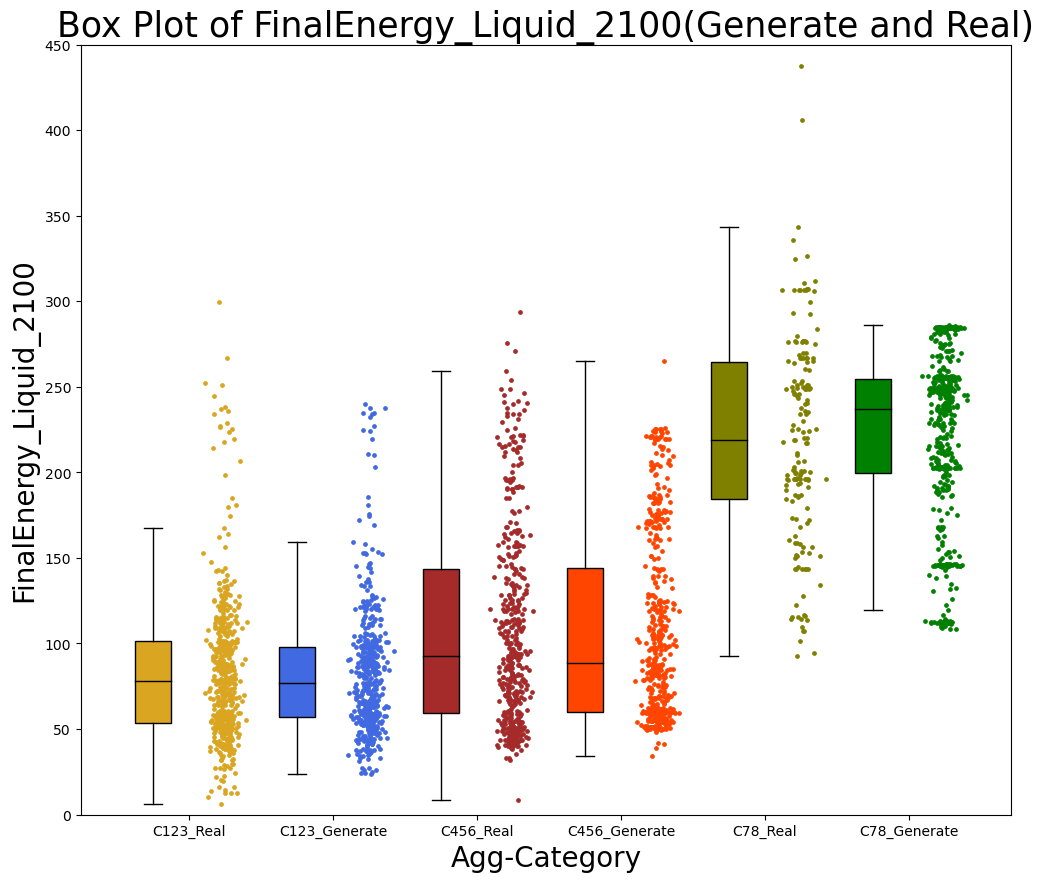

In [47]:
#FinalEnergy_Liquid_2100 real data versus generated data.
Category_names = ['C123_Real','C123_Generate','C456_Real','C456_Generate','C78_Real','C78_Generate']
Data_Values = [C123_FinalEnergy_Liquid_2100,Gen_C123[:,8,1],C456_FinalEnergy_Liquid_2100,Gen_C456[:,8,1],C78_FinalEnergy_Liquid_2100,Gen_C78[:,8,1]]
box_positions = np.arange(1, len(Category_names) + 1) - 0.25
scatter_positions = np.arange(1, len(Category_names) + 1) + 0.25

colors = ['goldenrod','royalblue','brown','orangered','olive','green','darkcyan','blueviolet']
plt.figure(figsize=(12,10))
box_plot = plt.boxplot(Data_Values,showfliers=False,patch_artist=True,widths=0.25,positions=box_positions)
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
for median_line in box_plot['medians']:
    median_line.set(color='black')
# scatterplot
for i, data in enumerate(Data_Values):
    x = np.random.normal(scatter_positions[i], 0.05, size=len(data))
    plt.scatter(x, data, color=colors[i], s=5.8)
plt.xlabel('Agg-Category',fontsize=20)
plt.ylabel('FinalEnergy_Liquid_2100',fontsize=20)
plt.title('Box Plot of FinalEnergy_Liquid_2100(Generate and Real)',fontsize=25)
# set scale
plt.xticks(range(1, len(Category_names) + 1), Category_names)
plt.ylim([0,450])
#plt.savefig('Box Plot of FinalEnergy_Liquid_2100(Generate and Real).pdf',format='pdf')
plt.show()

In [48]:
PrimaryEnergy_Coal_2100 = pd.DataFrame({'2100':X[:,8,2],'Category':Y})
C123_PrimaryEnergy_Coal_2100 = PrimaryEnergy_Coal_2100[PrimaryEnergy_Coal_2100['Category']== 0]['2100'].values
C456_PrimaryEnergy_Coal_2100 = PrimaryEnergy_Coal_2100[PrimaryEnergy_Coal_2100['Category']== 1]['2100'].values
C78_PrimaryEnergy_Coal_2100 = PrimaryEnergy_Coal_2100[PrimaryEnergy_Coal_2100['Category']== 2]['2100'].values

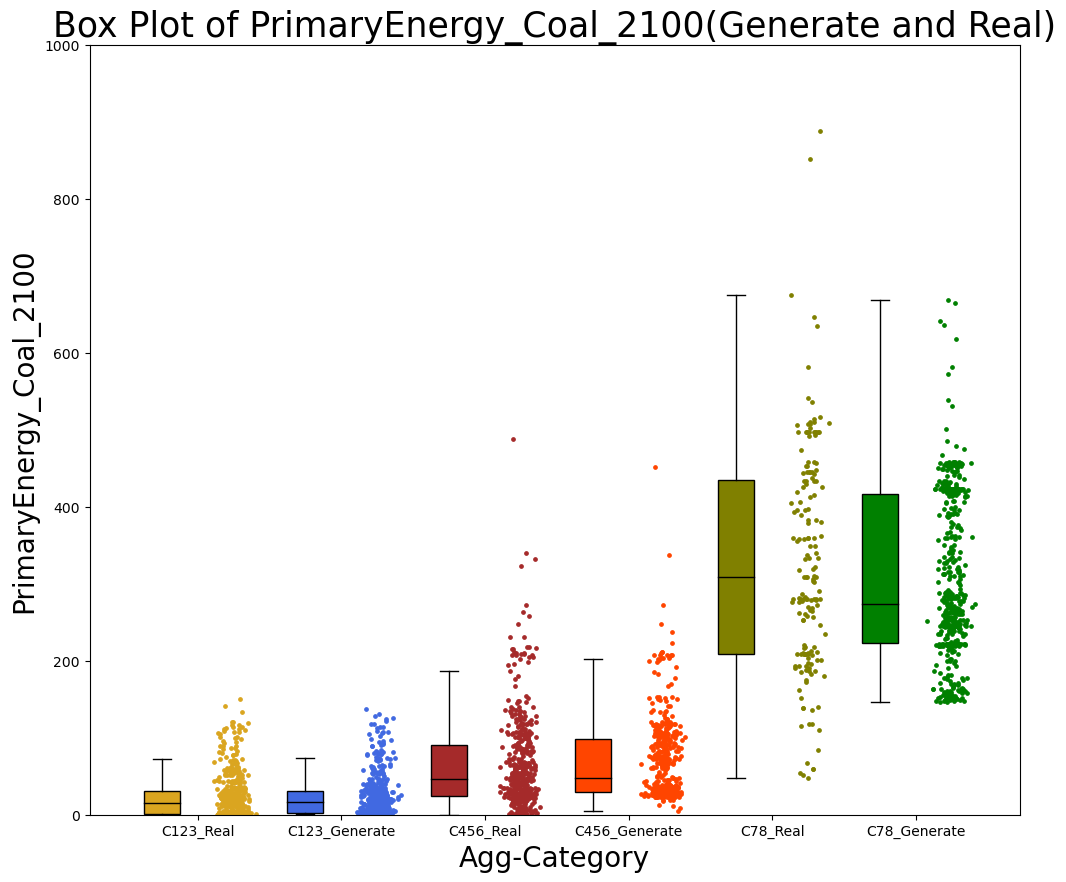

In [49]:
#PrimaryEnergy_Coal_2100 real data versus generated data.
Category_names = ['C123_Real','C123_Generate','C456_Real','C456_Generate','C78_Real','C78_Generate']
Data_Values = [C123_PrimaryEnergy_Coal_2100,Gen_C123[:,8,2],C456_PrimaryEnergy_Coal_2100,Gen_C456[:,8,2],C78_PrimaryEnergy_Coal_2100,Gen_C78[:,8,2]]
box_positions = np.arange(1, len(Category_names) + 1) - 0.25
scatter_positions = np.arange(1, len(Category_names) + 1) + 0.25

colors = ['goldenrod','royalblue','brown','orangered','olive','green','darkcyan','blueviolet']
plt.figure(figsize=(12,10))
box_plot = plt.boxplot(Data_Values,showfliers=False,patch_artist=True,widths=0.25,positions=box_positions)
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
for median_line in box_plot['medians']:
    median_line.set(color='black')
# scatterplot
for i, data in enumerate(Data_Values):
    x = np.random.normal(scatter_positions[i], 0.05, size=len(data))
    plt.scatter(x, data, color=colors[i], s=5.8)
plt.xlabel('Agg-Category',fontsize=20)
plt.ylabel('PrimaryEnergy_Coal_2100',fontsize=20)
plt.title('Box Plot of PrimaryEnergy_Coal_2100(Generate and Real)',fontsize=25)
# set scale
plt.xticks(range(1, len(Category_names) + 1), Category_names)
plt.ylim([0,1000])
#plt.savefig('Box Plot of PrimaryEnergy_Coal_2100(Generate and Real).pdf',format='pdf')
plt.show()

In [50]:
PrimaryEnergy_Gas_2100 = pd.DataFrame({'2100':X[:,8,3],'Category':Y})
C123_PrimaryEnergy_Gas_2100 = PrimaryEnergy_Gas_2100[PrimaryEnergy_Gas_2100['Category']== 0]['2100'].values
C456_PrimaryEnergy_Gas_2100 = PrimaryEnergy_Gas_2100[PrimaryEnergy_Gas_2100['Category']== 1]['2100'].values
C78_PrimaryEnergy_Gas_2100 = PrimaryEnergy_Gas_2100[PrimaryEnergy_Gas_2100['Category']== 2]['2100'].values

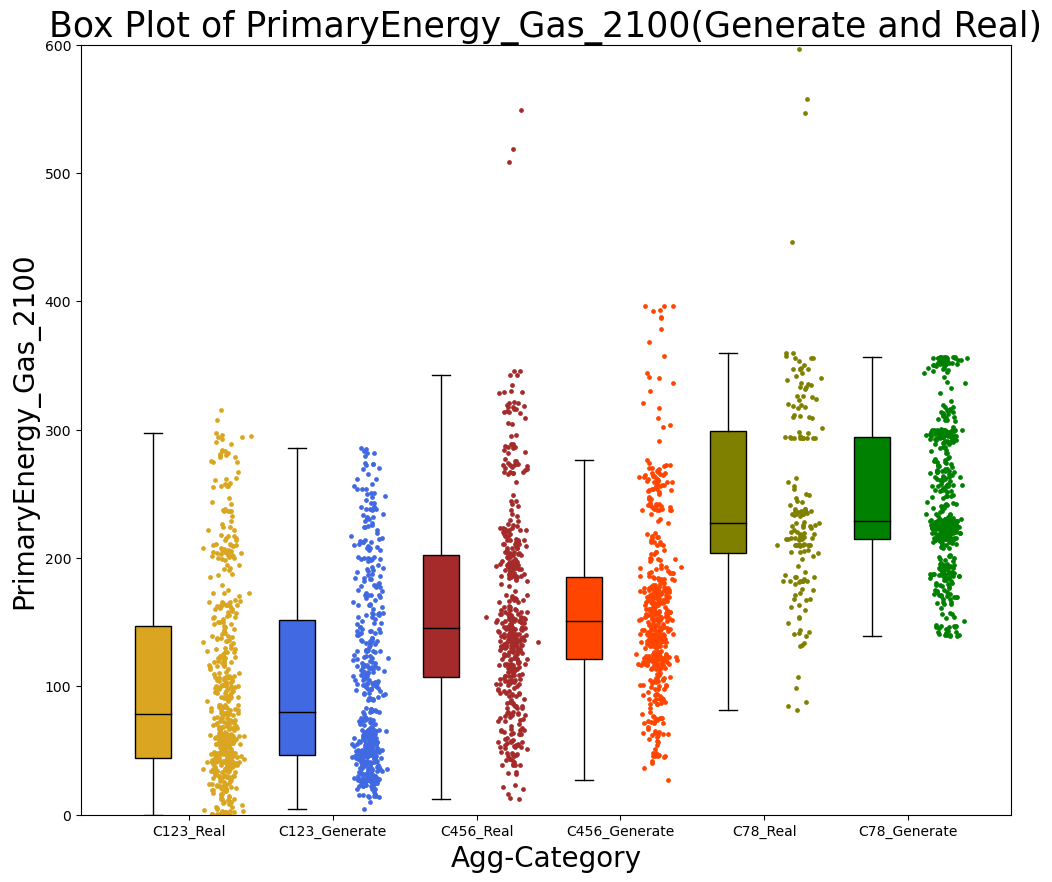

In [51]:
#PrimaryEnergy_Gas_2100 real data versus generated data.
Category_names = ['C123_Real','C123_Generate','C456_Real','C456_Generate','C78_Real','C78_Generate']
Data_Values = [C123_PrimaryEnergy_Gas_2100,Gen_C123[:,8,3],C456_PrimaryEnergy_Gas_2100,Gen_C456[:,8,3],C78_PrimaryEnergy_Gas_2100,Gen_C78[:,8,3]]
box_positions = np.arange(1, len(Category_names) + 1) - 0.25
scatter_positions = np.arange(1, len(Category_names) + 1) + 0.25

colors = ['goldenrod','royalblue','brown','orangered','olive','green','darkcyan','blueviolet']
plt.figure(figsize=(12,10))
box_plot = plt.boxplot(Data_Values,showfliers=False,patch_artist=True,widths=0.25,positions=box_positions)
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
for median_line in box_plot['medians']:
    median_line.set(color='black')
# scatterplot
for i, data in enumerate(Data_Values):
    x = np.random.normal(scatter_positions[i], 0.05, size=len(data))
    plt.scatter(x, data, color=colors[i], s=5.8)
plt.xlabel('Agg-Category',fontsize=20)
plt.ylabel('PrimaryEnergy_Gas_2100',fontsize=20)
plt.title('Box Plot of PrimaryEnergy_Gas_2100(Generate and Real)',fontsize=25)
# set scale
plt.xticks(range(1, len(Category_names) + 1), Category_names)
plt.ylim([0,600])
#plt.savefig('Box Plot of PrimaryEnergy_Gas_2100(Generate and Real).pdf',format='pdf')
plt.show()

In [52]:
PrimaryEnergy_Oil_2100 = pd.DataFrame({'2100':X[:,8,4],'Category':Y})
C123_PrimaryEnergy_Oil_2100 = PrimaryEnergy_Oil_2100[PrimaryEnergy_Oil_2100['Category']== 0]['2100'].values
C456_PrimaryEnergy_Oil_2100 = PrimaryEnergy_Oil_2100[PrimaryEnergy_Oil_2100['Category']== 1]['2100'].values
C78_PrimaryEnergy_Oil_2100 = PrimaryEnergy_Oil_2100[PrimaryEnergy_Oil_2100['Category']== 2]['2100'].values

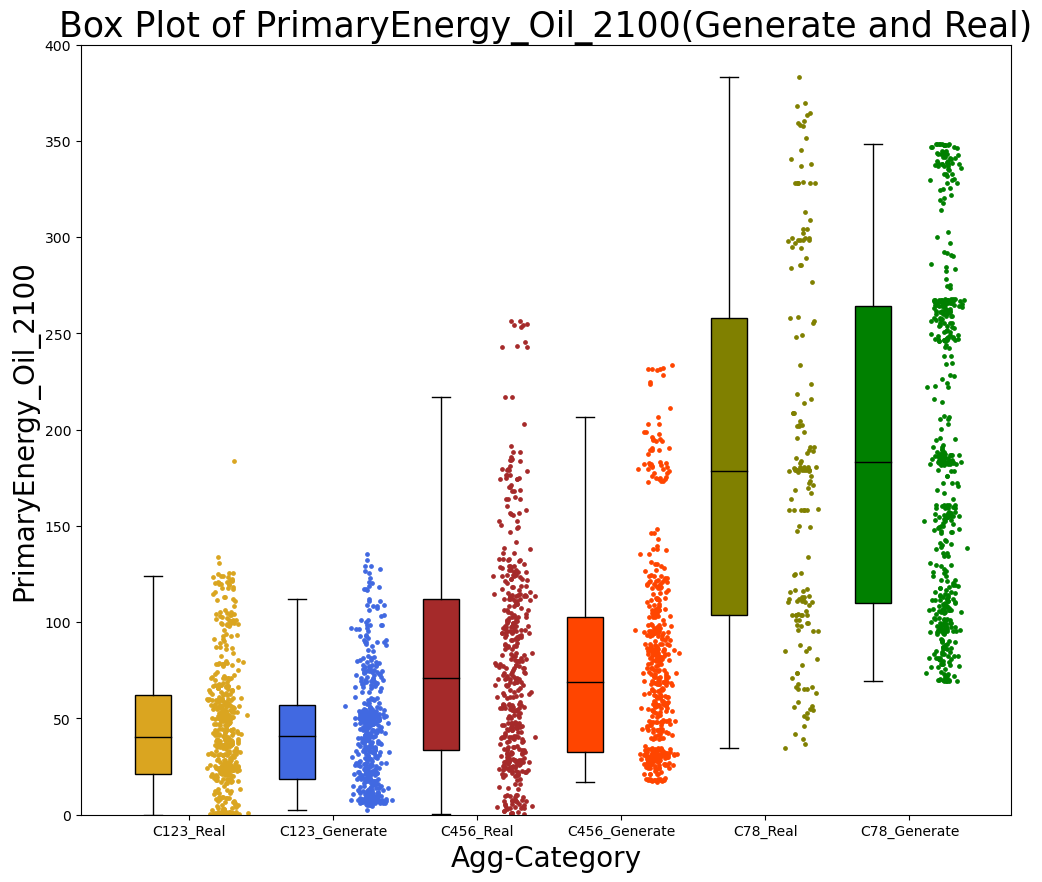

In [53]:
#PrimaryEnergy_Oil_2100 real data versus generated data.
Category_names = ['C123_Real','C123_Generate','C456_Real','C456_Generate','C78_Real','C78_Generate']
Data_Values = [C123_PrimaryEnergy_Oil_2100,Gen_C123[:,8,4],C456_PrimaryEnergy_Oil_2100,Gen_C456[:,8,4],C78_PrimaryEnergy_Oil_2100,Gen_C78[:,8,4]]
box_positions = np.arange(1, len(Category_names) + 1) - 0.25
scatter_positions = np.arange(1, len(Category_names) + 1) + 0.25

colors = ['goldenrod','royalblue','brown','orangered','olive','green','darkcyan','blueviolet']
plt.figure(figsize=(12,10))
box_plot = plt.boxplot(Data_Values,showfliers=False,patch_artist=True,widths=0.25,positions=box_positions)
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
for median_line in box_plot['medians']:
    median_line.set(color='black')
# scatterplot
for i, data in enumerate(Data_Values):
    x = np.random.normal(scatter_positions[i], 0.05, size=len(data))
    plt.scatter(x, data, color=colors[i], s=5.8)
plt.xlabel('Agg-Category',fontsize=20)
plt.ylabel('PrimaryEnergy_Oil_2100',fontsize=20)
plt.title('Box Plot of PrimaryEnergy_Oil_2100(Generate and Real)',fontsize=25)
# set scale
plt.xticks(range(1, len(Category_names) + 1), Category_names)
plt.ylim([0,400])
#plt.savefig('Box Plot of PrimaryEnergy_Oil_2100(Generate and Real).pdf',format='pdf')
plt.show()

In [54]:
Kyoto_Gases_2100 = pd.DataFrame({'2100':X[:,8,5],'Category':Y})
C123_Kyoto_Gases_2100 = Kyoto_Gases_2100[Kyoto_Gases_2100['Category']== 0]['2100'].values
C456_Kyoto_Gases_2100 = Kyoto_Gases_2100[Kyoto_Gases_2100['Category']== 1]['2100'].values
C78_Kyoto_Gases_2100 = Kyoto_Gases_2100[Kyoto_Gases_2100['Category']== 2]['2100'].values

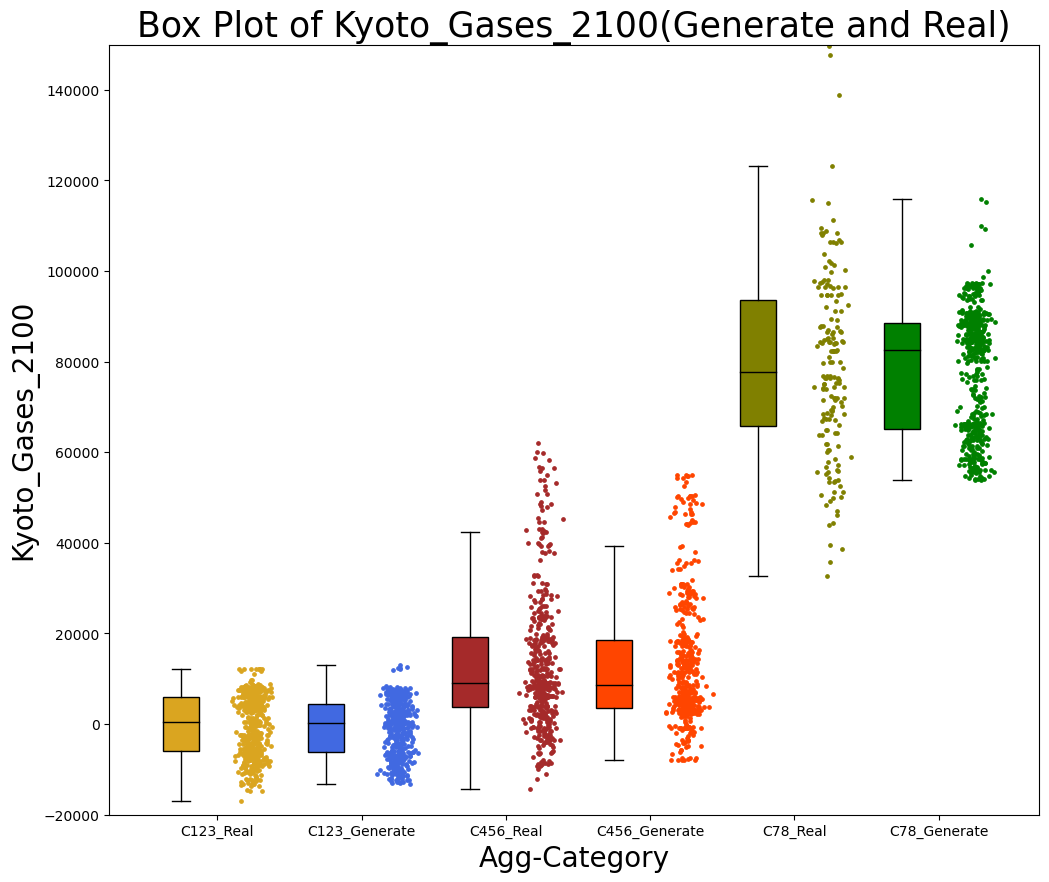

In [55]:
#Kyoto_Gases_2100 real data versus generated data.
Category_names = ['C123_Real','C123_Generate','C456_Real','C456_Generate','C78_Real','C78_Generate']
Data_Values = [C123_Kyoto_Gases_2100,Gen_C123[:,8,5],C456_Kyoto_Gases_2100,Gen_C456[:,8,5],C78_Kyoto_Gases_2100,Gen_C78[:,8,5]]
box_positions = np.arange(1, len(Category_names) + 1) - 0.25
scatter_positions = np.arange(1, len(Category_names) + 1) + 0.25

colors = ['goldenrod','royalblue','brown','orangered','olive','green','darkcyan','blueviolet']
plt.figure(figsize=(12,10))
box_plot = plt.boxplot(Data_Values,showfliers=False,patch_artist=True,widths=0.25,positions=box_positions)
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
for median_line in box_plot['medians']:
    median_line.set(color='black')
# scatterplot
for i, data in enumerate(Data_Values):
    x = np.random.normal(scatter_positions[i], 0.05, size=len(data))
    plt.scatter(x, data, color=colors[i], s=5.8)
plt.xlabel('Agg-Category',fontsize=20)
plt.ylabel('Kyoto_Gases_2100',fontsize=20)
plt.title('Box Plot of Kyoto_Gases_2100(Generate and Real)',fontsize=25)
# set scale
plt.xticks(range(1, len(Category_names) + 1), Category_names)
plt.ylim([-20000,150000])
#plt.savefig('Box Plot of Kyoto_Gases_2100(Generate and Real).pdf',format='pdf')
plt.show()

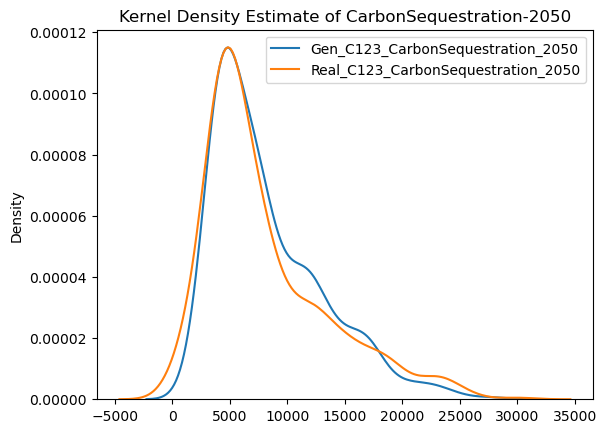

Kolmogorov-Smirnov Test p_value = 0.0626290777825464


In [56]:
from scipy.stats import ks_2samp
Data =[Gen_C123[:,3,0],C123_CarbonSequestration_2050]

statistic, p_value = ks_2samp(Data[0], Data[1])

sns.kdeplot(Data[0],label='Gen_C123_CarbonSequestration_2050')
sns.kdeplot(Data[1],label='Real_C123_CarbonSequestration_2050')
plt.title("Kernel Density Estimate of CarbonSequestration-2050")
plt.legend()
plt.show()
print(f'Kolmogorov-Smirnov Test p_value = {p_value}')

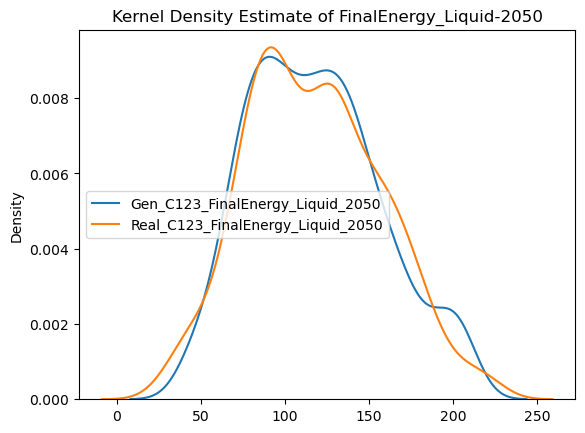

Kolmogorov-Smirnov Test p_value = 0.9868908944604609


In [57]:
Data =[Gen_C123[:,3,1],C123_FinalEnergy_Liquid_2050]

statistic, p_value = ks_2samp(Data[0], Data[1])

sns.kdeplot(Data[0],label='Gen_C123_FinalEnergy_Liquid_2050')
sns.kdeplot(Data[1],label='Real_C123_FinalEnergy_Liquid_2050')
plt.title("Kernel Density Estimate of FinalEnergy_Liquid-2050")
plt.legend()
plt.show()
print(f'Kolmogorov-Smirnov Test p_value = {p_value}')

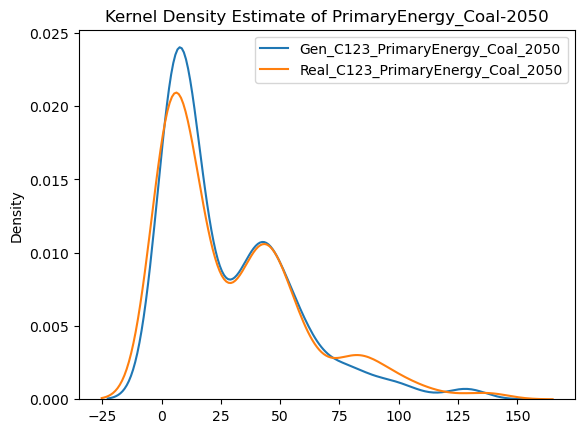

Kolmogorov-Smirnov Test p_value = 1.3629376995290108e-07


In [58]:
Data =[Gen_C123[:,3,2],C123_PrimaryEnergy_Coal_2050]

statistic, p_value = ks_2samp(Data[0], Data[1])

sns.kdeplot(Data[0],label='Gen_C123_PrimaryEnergy_Coal_2050')
sns.kdeplot(Data[1],label='Real_C123_PrimaryEnergy_Coal_2050')
plt.title("Kernel Density Estimate of PrimaryEnergy_Coal-2050")
plt.legend()
plt.show()
print(f'Kolmogorov-Smirnov Test p_value = {p_value}')


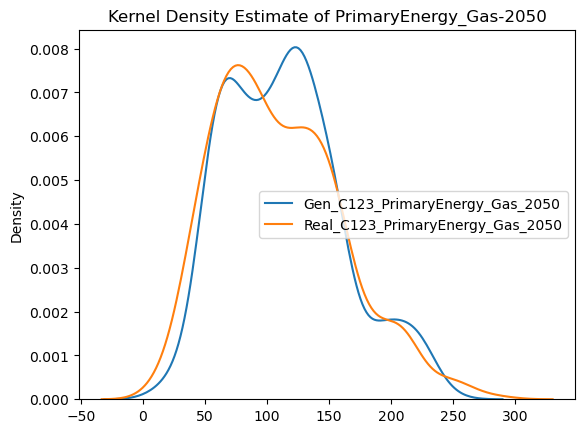

Kolmogorov-Smirnov Test p_value = 0.08638318964924023


In [59]:
Data =[Gen_C123[:,3,3],C123_PrimaryEnergy_Gas_2050]

statistic, p_value = ks_2samp(Data[0], Data[1])

sns.kdeplot(Data[0],label='Gen_C123_PrimaryEnergy_Gas_2050')
sns.kdeplot(Data[1],label='Real_C123_PrimaryEnergy_Gas_2050')
plt.title("Kernel Density Estimate of PrimaryEnergy_Gas-2050")
plt.legend()
plt.show()
print(f'Kolmogorov-Smirnov Test p_value = {p_value}')


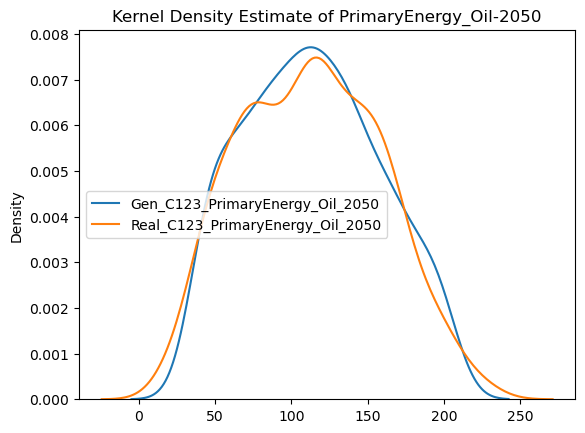

Kolmogorov-Smirnov Test p_value = 0.7495277351315561


In [60]:
Data =[Gen_C123[:,3,4],C123_PrimaryEnergy_Oil_2050]

statistic, p_value = ks_2samp(Data[0], Data[1])

sns.kdeplot(Data[0],label='Gen_C123_PrimaryEnergy_Oil_2050')
sns.kdeplot(Data[1],label='Real_C123_PrimaryEnergy_Oil_2050')
plt.title("Kernel Density Estimate of PrimaryEnergy_Oil-2050")
plt.legend()
plt.show()
print(f'Kolmogorov-Smirnov Test p_value = {p_value}')


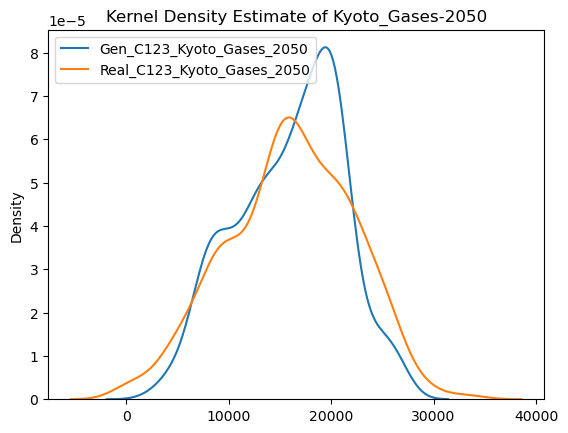

Kolmogorov-Smirnov Test p_value = 0.008246678797168895


In [61]:
Data =[Gen_C123[:,3,5],C123_Kyoto_Gases_2050]

statistic, p_value = ks_2samp(Data[0], Data[1])

sns.kdeplot(Data[0],label='Gen_C123_Kyoto_Gases_2050')
sns.kdeplot(Data[1],label='Real_C123_Kyoto_Gases_2050')
plt.title("Kernel Density Estimate of Kyoto_Gases-2050")
plt.legend()
plt.show()
print(f'Kolmogorov-Smirnov Test p_value = {p_value}')


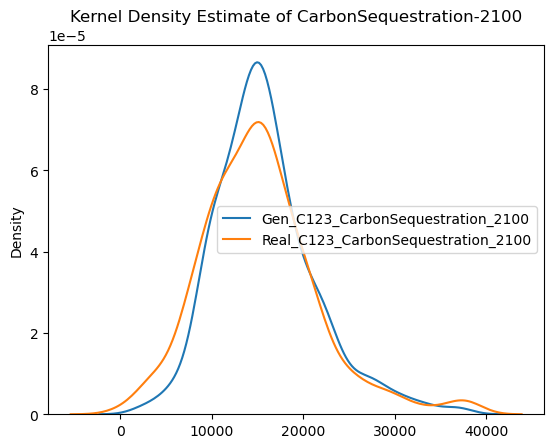

Kolmogorov-Smirnov Test p_value = 0.004913188320644735


In [62]:
Data =[Gen_C123[:,8,0],C123_CarbonSequestration_2100]

statistic, p_value = ks_2samp(Data[0], Data[1])

sns.kdeplot(Data[0],label='Gen_C123_CarbonSequestration_2100')
sns.kdeplot(Data[1],label='Real_C123_CarbonSequestration_2100')
plt.title("Kernel Density Estimate of CarbonSequestration-2100")
plt.legend()
plt.show()
print(f'Kolmogorov-Smirnov Test p_value = {p_value}')

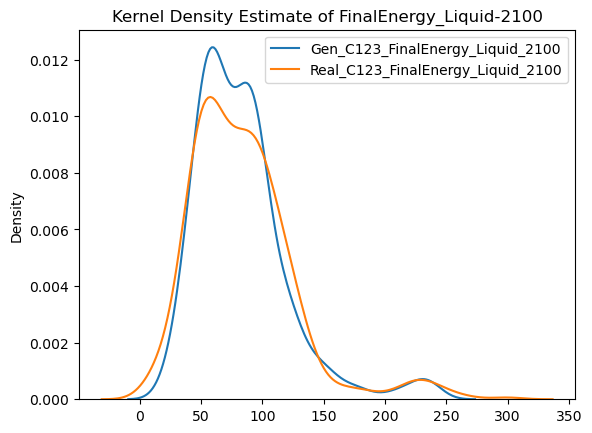

Kolmogorov-Smirnov Test p_value = 0.2594721315384082


In [63]:
Data =[Gen_C123[:,8,1],C123_FinalEnergy_Liquid_2100]

statistic, p_value = ks_2samp(Data[0], Data[1])

sns.kdeplot(Data[0],label='Gen_C123_FinalEnergy_Liquid_2100')
sns.kdeplot(Data[1],label='Real_C123_FinalEnergy_Liquid_2100')
plt.title("Kernel Density Estimate of FinalEnergy_Liquid-2100")
plt.legend()
plt.show()
print(f'Kolmogorov-Smirnov Test p_value = {p_value}')

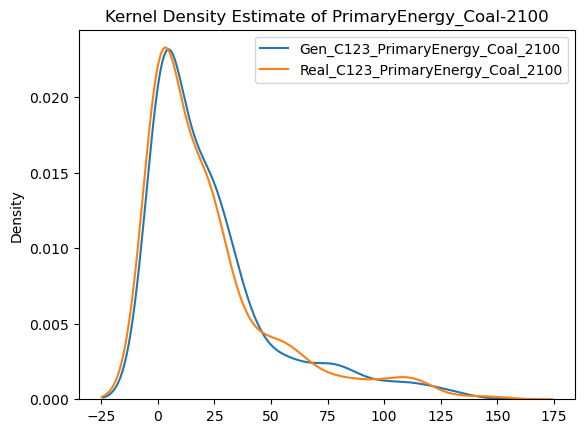

Kolmogorov-Smirnov Test p_value = 4.096093473866191e-09


In [64]:
Data =[Gen_C123[:,8,2],C123_PrimaryEnergy_Coal_2100]

statistic, p_value = ks_2samp(Data[0], Data[1])

sns.kdeplot(Data[0],label='Gen_C123_PrimaryEnergy_Coal_2100')
sns.kdeplot(Data[1],label='Real_C123_PrimaryEnergy_Coal_2100')
plt.title("Kernel Density Estimate of PrimaryEnergy_Coal-2100")
plt.legend()
plt.show()
print(f'Kolmogorov-Smirnov Test p_value = {p_value}')

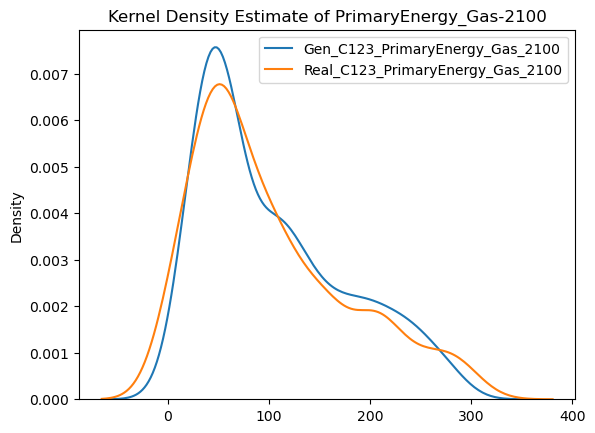

Kolmogorov-Smirnov Test p_value = 0.1218677716711486


In [65]:
Data =[Gen_C123[:,8,3],C123_PrimaryEnergy_Gas_2100]

statistic, p_value = ks_2samp(Data[0], Data[1])

sns.kdeplot(Data[0],label='Gen_C123_PrimaryEnergy_Gas_2100')
sns.kdeplot(Data[1],label='Real_C123_PrimaryEnergy_Gas_2100')
plt.title("Kernel Density Estimate of PrimaryEnergy_Gas-2100")
plt.legend()
plt.show()
print(f'Kolmogorov-Smirnov Test p_value = {p_value}')

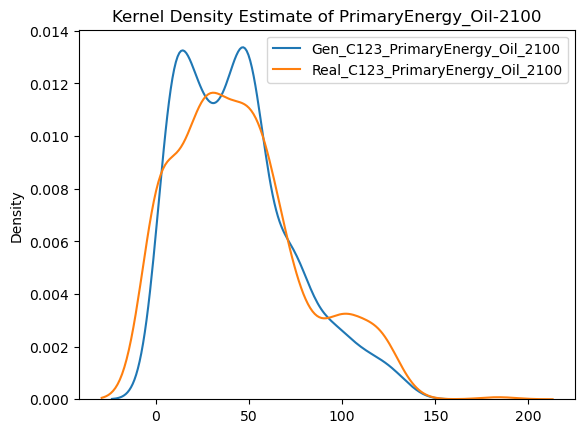

Kolmogorov-Smirnov Test p_value = 4.8513859820731054e-05


In [66]:
Data =[Gen_C123[:,8,4],C123_PrimaryEnergy_Oil_2100]

statistic, p_value = ks_2samp(Data[0], Data[1])

sns.kdeplot(Data[0],label='Gen_C123_PrimaryEnergy_Oil_2100')
sns.kdeplot(Data[1],label='Real_C123_PrimaryEnergy_Oil_2100')
plt.title("Kernel Density Estimate of PrimaryEnergy_Oil-2100")
plt.legend()
plt.show()
print(f'Kolmogorov-Smirnov Test p_value = {p_value}')

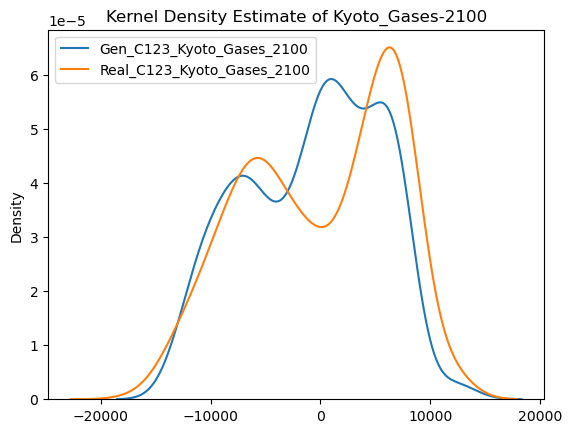

Kolmogorov-Smirnov Test p_value = 0.00021628745061180564


In [67]:
Data =[Gen_C123[:,8,5],C123_Kyoto_Gases_2100]

statistic, p_value = ks_2samp(Data[0], Data[1])

sns.kdeplot(Data[0],label='Gen_C123_Kyoto_Gases_2100')
sns.kdeplot(Data[1],label='Real_C123_Kyoto_Gases_2100')
plt.title("Kernel Density Estimate of Kyoto_Gases-2100")
plt.legend()
plt.show()
print(f'Kolmogorov-Smirnov Test p_value = {p_value}')


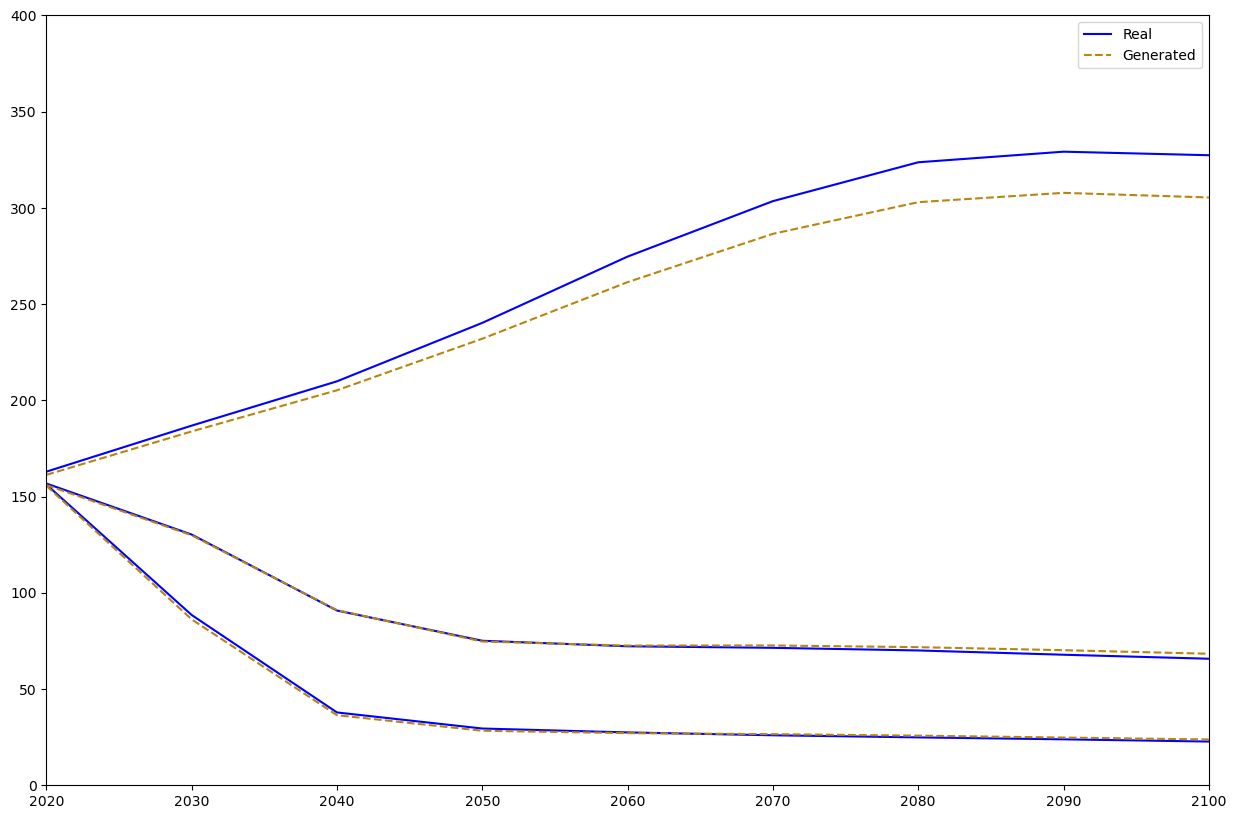

In [68]:
#PrimaryEnergy_Coal
plt.figure(figsize=(15,10))
plt.plot(np.arange(2020,2101,10),C123_DataSet[:,:,2].mean(axis=0),color='blue',label='Real')
plt.plot(np.arange(2020,2101,10),np.array(Gen_C123[:,:,2]).mean(axis=0),color='darkgoldenrod',linestyle='--',label='Generated')
plt.plot(np.arange(2020,2101,10),C456_DataSet[:,:,2].mean(axis=0),color='blue')
plt.plot(np.arange(2020,2101,10),np.array(Gen_C456[:,:,2]).mean(axis=0),color='darkgoldenrod',linestyle='--')
plt.plot(np.arange(2020,2101,10),C78_DataSet[:,:,2].mean(axis=0),color='blue')
plt.plot(np.arange(2020,2101,10),np.array(Gen_C78[:,:,2]).mean(axis=0),color='darkgoldenrod',linestyle='--')
plt.ylim([0,400])
plt.xlim([2020,2100])
plt.legend()
#plt.savefig('PrimaryEnergy_Coal Plot.pdf',format='pdf')
plt.show()

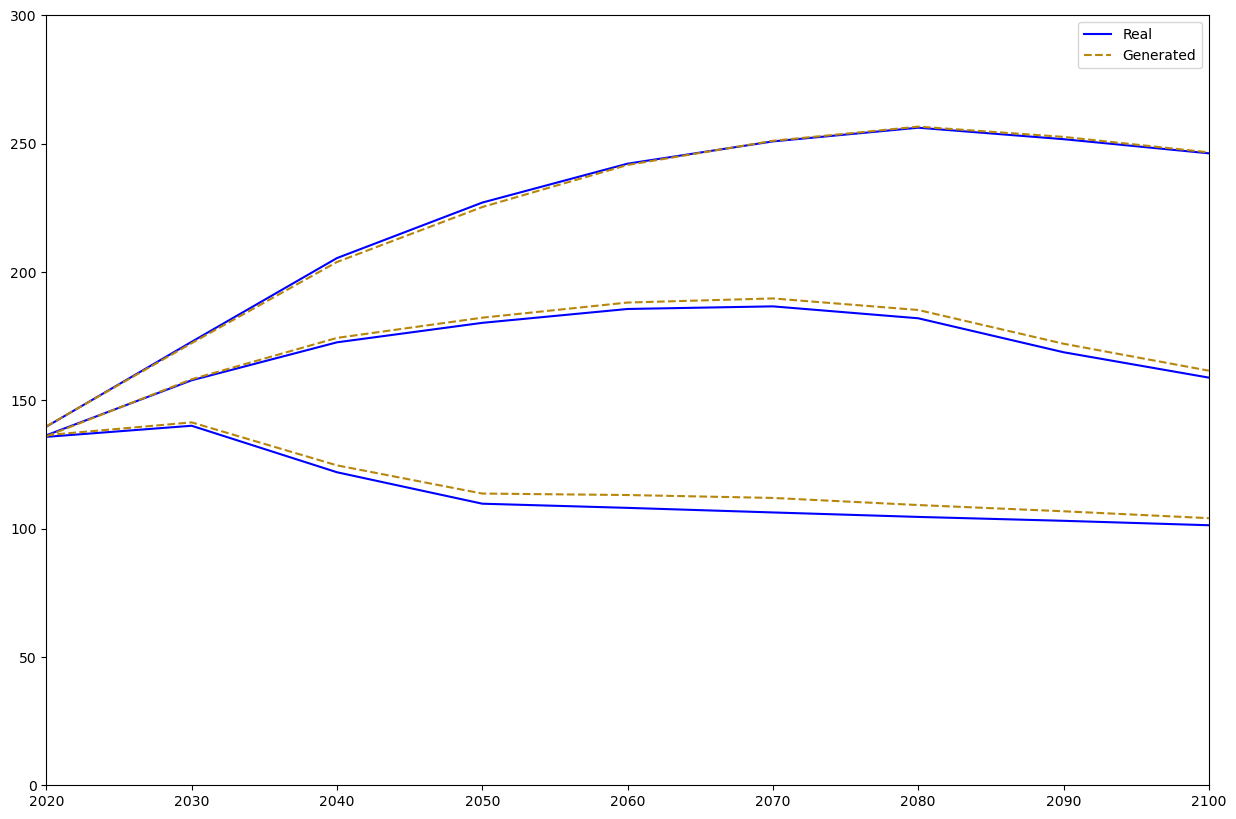

In [69]:
#PrimaryEnergy_Gas
plt.figure(figsize=(15,10))
plt.plot(np.arange(2020,2101,10),C123_DataSet[:,:,3].mean(axis=0),color='blue',label='Real')
plt.plot(np.arange(2020,2101,10),np.array(Gen_C123[:,:,3]).mean(axis=0),color='darkgoldenrod',linestyle='--',label='Generated')
plt.plot(np.arange(2020,2101,10),C456_DataSet[:,:,3].mean(axis=0),color='blue')
plt.plot(np.arange(2020,2101,10),np.array(Gen_C456[:,:,3]).mean(axis=0),color='darkgoldenrod',linestyle='--')
plt.plot(np.arange(2020,2101,10),C78_DataSet[:,:,3].mean(axis=0),color='blue')
plt.plot(np.arange(2020,2101,10),np.array(Gen_C78[:,:,3]).mean(axis=0),color='darkgoldenrod',linestyle='--')
plt.ylim([0,300])
plt.xlim([2020,2100])
plt.legend()
#plt.savefig('PrimaryEnergy_Gas Plot.pdf',format='pdf')
plt.show()

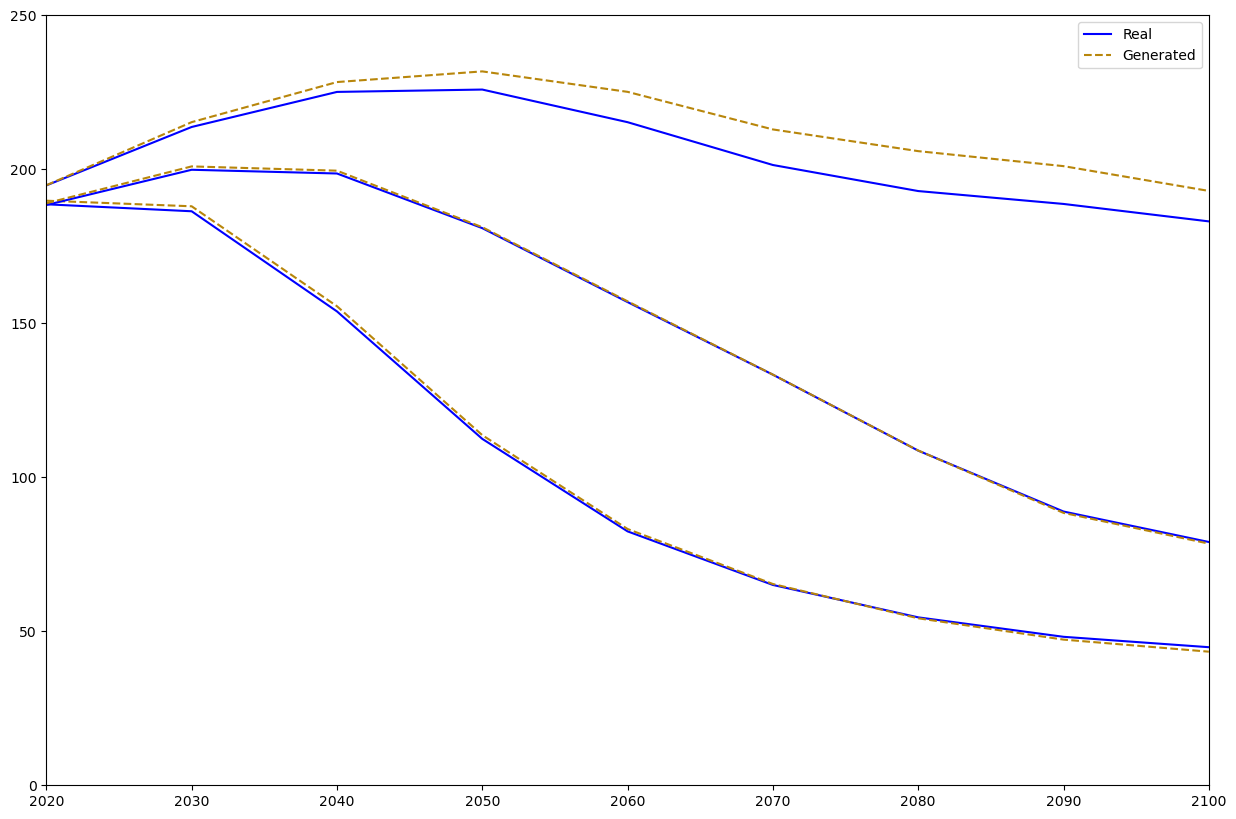

In [70]:
#PrimaryEnergy_Gas
plt.figure(figsize=(15,10))
plt.plot(np.arange(2020,2101,10),C123_DataSet[:,:,4].mean(axis=0),color='blue',label='Real')
plt.plot(np.arange(2020,2101,10),np.array(Gen_C123[:,:,4]).mean(axis=0),color='darkgoldenrod',linestyle='--',label='Generated')
plt.plot(np.arange(2020,2101,10),C456_DataSet[:,:,4].mean(axis=0),color='blue')
plt.plot(np.arange(2020,2101,10),np.array(Gen_C456[:,:,4]).mean(axis=0),color='darkgoldenrod',linestyle='--')
plt.plot(np.arange(2020,2101,10),C78_DataSet[:,:,4].mean(axis=0),color='blue')
plt.plot(np.arange(2020,2101,10),np.array(Gen_C78[:,:,4]).mean(axis=0),color='darkgoldenrod',linestyle='--')
plt.ylim([0,250])
plt.xlim([2020,2100])
plt.legend()
#plt.savefig('PrimaryEnergy_Oil Plot.pdf',format='pdf')
plt.show()

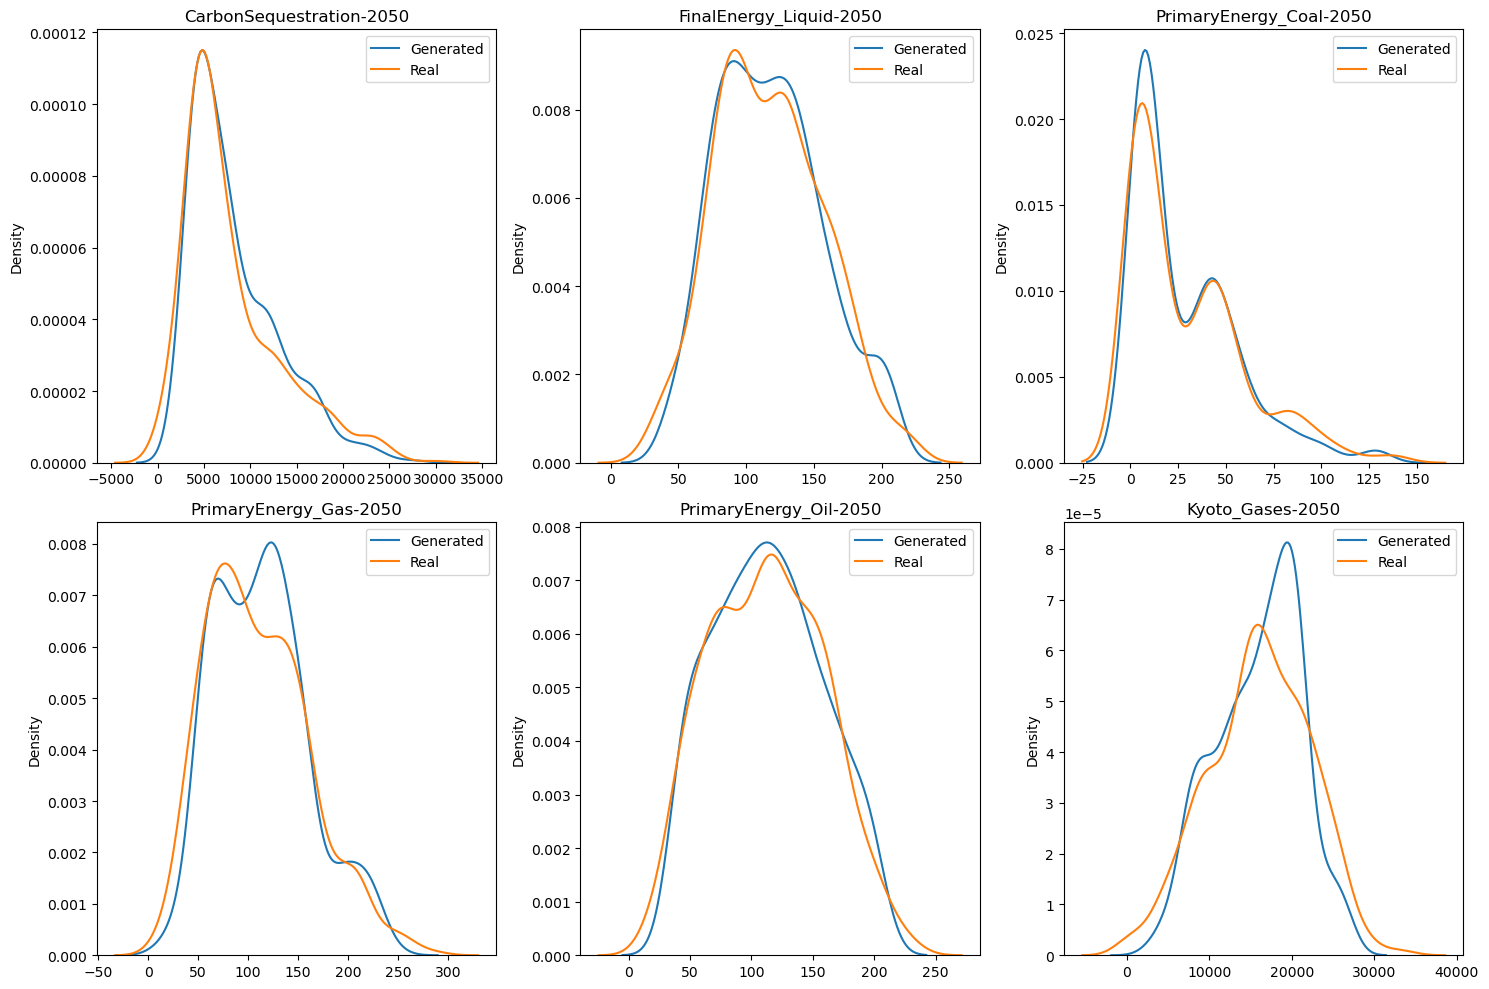

In [71]:
fig,axes = plt.subplots(2,3,figsize=(15,10))

sns.kdeplot(Gen_C123[:,3,0],ax=axes[0,0],label='Generated')
sns.kdeplot(C123_CarbonSequestration_2050,ax=axes[0,0],label='Real')
axes[0,0].set_title("CarbonSequestration-2050")
axes[0,0].legend()

sns.kdeplot(Gen_C123[:,3,1],ax=axes[0,1],label='Generated')
sns.kdeplot(C123_FinalEnergy_Liquid_2050,ax=axes[0,1],label='Real')
axes[0,1].set_title("FinalEnergy_Liquid-2050")
axes[0,1].legend()

sns.kdeplot(Gen_C123[:,3,2],ax=axes[0,2],label='Generated')
sns.kdeplot(C123_PrimaryEnergy_Coal_2050,ax=axes[0,2],label='Real')
axes[0,2].set_title("PrimaryEnergy_Coal-2050")
axes[0,2].legend()

sns.kdeplot(Gen_C123[:,3,3],ax=axes[1,0],label='Generated')
sns.kdeplot(C123_PrimaryEnergy_Gas_2050,ax=axes[1,0],label='Real')
axes[1,0].set_title("PrimaryEnergy_Gas-2050")
axes[1,0].legend()

sns.kdeplot(Gen_C123[:,3,4],ax=axes[1,1],label='Generated')
sns.kdeplot(C123_PrimaryEnergy_Oil_2050,ax=axes[1,1],label='Real')
axes[1,1].set_title('PrimaryEnergy_Oil-2050')
axes[1,1].legend()

sns.kdeplot(Gen_C123[:,3,5],ax=axes[1,2],label='Generated')
sns.kdeplot(C123_Kyoto_Gases_2050,ax=axes[1,2],label='Real')
axes[1,2].set_title("Kyoto_Gases-2050")
axes[1,2].legend()
#plt.savefig('Kernel Density of 2050.pdf',format='pdf',bbox_inches='tight')
plt.tight_layout()
plt.show()

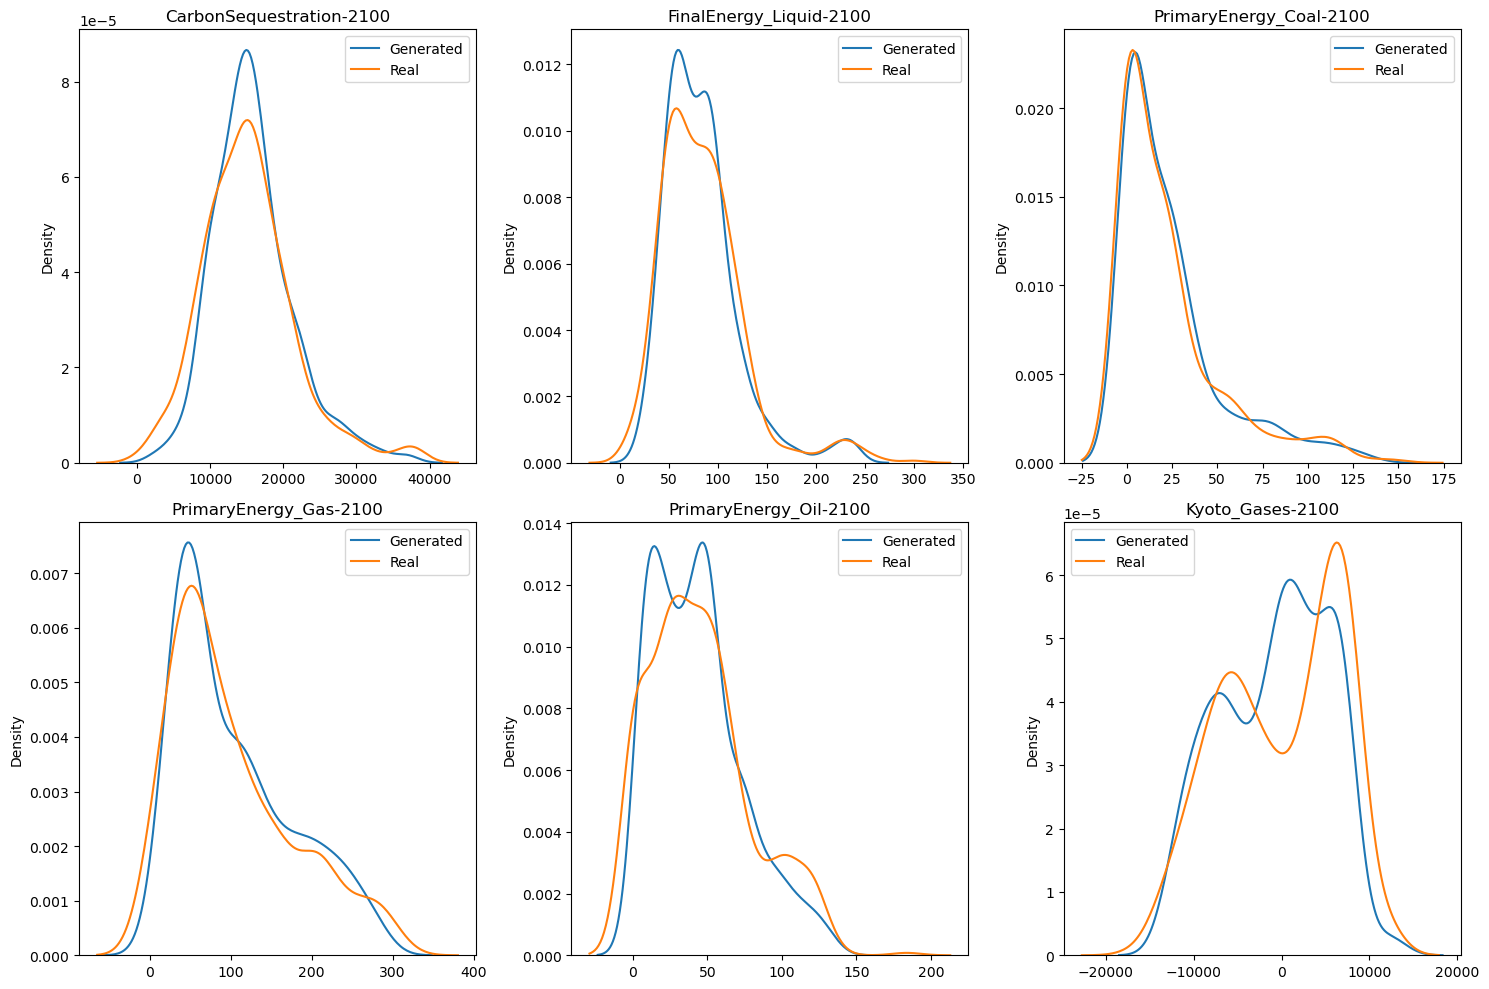

In [72]:
fig,axes = plt.subplots(2,3,figsize=(15,10))

sns.kdeplot(Gen_C123[:,8,0],ax=axes[0,0],label='Generated')
sns.kdeplot(C123_CarbonSequestration_2100,ax=axes[0,0],label='Real')
axes[0,0].set_title("CarbonSequestration-2100")
axes[0,0].legend()

sns.kdeplot(Gen_C123[:,8,1],ax=axes[0,1],label='Generated')
sns.kdeplot(C123_FinalEnergy_Liquid_2100,ax=axes[0,1],label='Real')
axes[0,1].set_title("FinalEnergy_Liquid-2100")
axes[0,1].legend()

sns.kdeplot(Gen_C123[:,8,2],ax=axes[0,2],label='Generated')
sns.kdeplot(C123_PrimaryEnergy_Coal_2100,ax=axes[0,2],label='Real')
axes[0,2].set_title("PrimaryEnergy_Coal-2100")
axes[0,2].legend()

sns.kdeplot(Gen_C123[:,8,3],ax=axes[1,0],label='Generated')
sns.kdeplot(C123_PrimaryEnergy_Gas_2100,ax=axes[1,0],label='Real')
axes[1,0].set_title("PrimaryEnergy_Gas-2100")
axes[1,0].legend()

sns.kdeplot(Gen_C123[:,8,4],ax=axes[1,1],label='Generated')
sns.kdeplot(C123_PrimaryEnergy_Oil_2100,ax=axes[1,1],label='Real')
axes[1,1].set_title("PrimaryEnergy_Oil-2100")
axes[1,1].legend()

sns.kdeplot(Gen_C123[:,8,5],ax=axes[1,2],label='Generated')
sns.kdeplot(C123_Kyoto_Gases_2100,ax=axes[1,2],label='Real')
axes[1,2].set_title("Kyoto_Gases-2100")
axes[1,2].legend()
#plt.savefig('Kernel Density of 2100.pdf',format='pdf',bbox_inches='tight')
plt.tight_layout()
plt.show()